In [14]:
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')

import itertools
import random

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

def seasonal_check(df):

  decomposition = seasonal_decompose(df.incremental_cases, model = 'additive', period = 30)
  plt.figure(figsize=(12, 8))

  plt.subplot(4, 1, 1)
  plt.plot(df.date, df.incremental_cases, label='Original', color='blue')
  plt.legend(loc='upper left')
  plt.title('Original Time Series')

  plt.subplot(4, 1, 2)
  plt.plot(df.date, decomposition.trend, label='Trend', color='red')
  plt.legend(loc='upper left')
  plt.title('Trend Component')

  plt.subplot(4, 1, 3)
  plt.plot(df.date, decomposition.seasonal, label='Seasonal', color='green')
  plt.legend(loc='upper left')
  plt.title('Seasonal Component')

  plt.subplot(4, 1, 4)
  plt.plot(df.date, decomposition.resid, label='Residual', color='purple')
  plt.legend(loc='upper left')
  plt.title('Residual Component')

  plt.tight_layout()
  plt.show()

data = pd.read_csv('finalized_county.csv').iloc[:, 1:]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.1 MB/s eta 0:00:00


# UPDATED CODE
### Full process of ARIMA, SARIMA, and Auto-ARIMA tuning
https://mail.google.com/mail/u/0/?ogbl#inbox/KtbxLvhRXHBqDPCzfwbBqBnbxqzfWJjngV

https://mail.google.com/mail/u/0/?ogbl#inbox/KtbxLvhRXHBqDPCzfwbBqBnbxqzfWJjngV


## New York City

(-4.027742630367559, 0.0012720104380451068)


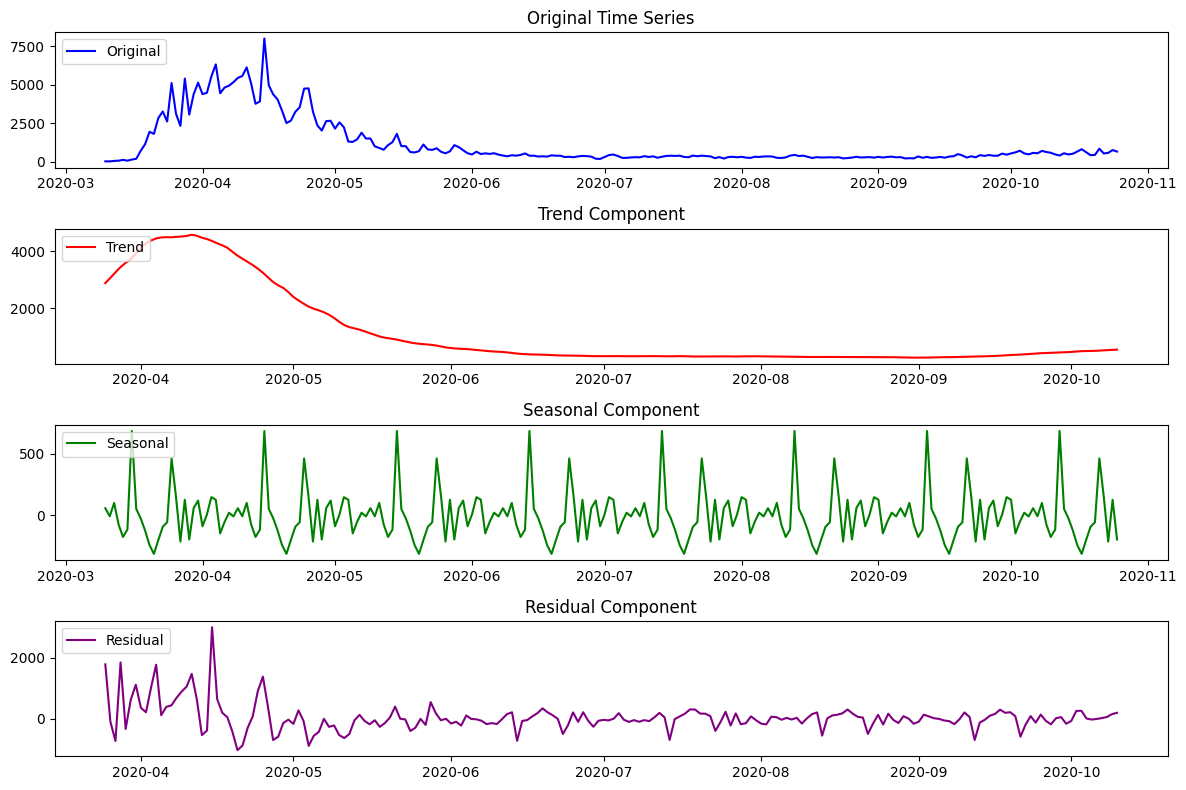

In [2]:
nyc = data[data['county'] == 'New York City'].loc[:, ['date', 'incremental_cases']]
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]

# NYC data is stationary without any differencing
print(stationary_test(train.incremental_cases))

# check for seasonality
seasonal_check(train)

In [3]:
def differencing(timeseries, m):
    info = []
    for i in range(3):
        timeseries.name = f"d{i}_D0_m0"
        info.append(timeseries)
        timeseries = timeseries.diff()

    for i in m:
        for j in range(3):
            timeseries = info[j].diff(periods=i)
            timeseries.name = f"d{j}_D1_m{i}"
            info.append(timeseries)

    for i in m:
        for j in range(3):
            timeseries = info[j+3].diff(periods=i)
            timeseries.name = f"d{j}_D2_m{i}"
            info.append(timeseries)

    return pd.DataFrame(info).T

diff_series = differencing(train.incremental_cases, [30])
# combination of possible d, D, and m
diff_series

,d0_D0_m0,d1_D0_m0,d2_D0_m0,d0_D1_m30,d1_D1_m30,d2_D1_m30,d0_D2_m30,d1_D2_m30,d2_D2_m30
1890,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891,15.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1892,44.0,29.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN
1893,59.0,15.0,-14.0,NaN,NaN,NaN,NaN,NaN,NaN
1894,114.0,55.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2115,842.0,406.0,390.0,580.0,545.0,441.0,583.0,665.0,460.0
2116,531.0,-311.0,-717.0,183.0,-397.0,-942.0,123.0,-460.0,-1125.0
2117,570.0,39.0,350.0,289.0,106.0,503.0,218.0,95.0,555.0
2118,752.0,182.0,143.0,330.0,41.0,-65.0,139.0,-79.0,-174.0


In [4]:
# check the stationary status of each combination
def adf_summary(diff_series):
    summary = []
    for i in diff_series:
        a, b, c, d, e, f = adfuller(diff_series[i].dropna())
        g, h, i = e.values()
        results = [a, b, c, d, g, h, i]
        summary.append(results)

    columns = ["Test Statistic", "p-value", "#Lags Used", "No. of Obs. Used",
               "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"]

    index = diff_series.columns
    summary = pd.DataFrame(summary, index=index, columns=columns)

    return summary

summary = adf_summary(diff_series)
summary_passed = summary[summary["p-value"] < 0.05]

index_list = pd.Index.tolist(summary_passed.index)
passed_series = diff_series[index_list]
ps = passed_series.sort_index(axis=1)

<Axes: title={'center': 'Possible AR Terms'}, xlabel='nth lag', ylabel='Sum of PACF'>

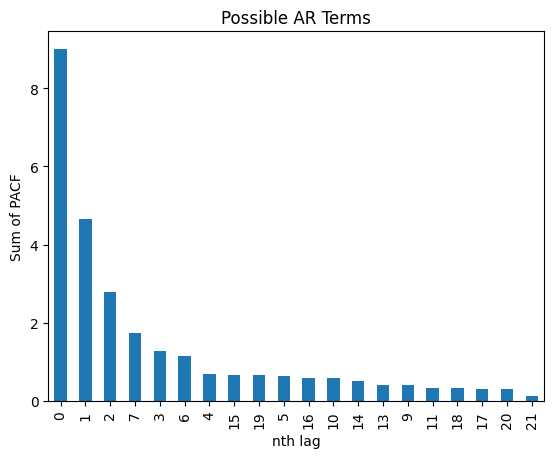

In [11]:
df_sp_p = pd.DataFrame()
AR = []
for i in ps:
    PACF, PACF_ci = pacf(ps[i].dropna(), alpha=0.05, method='ywm')

    # subtract the upper and lower limits of CI by ACF to centre CI at zero
    PACF_ci_ll = PACF_ci[:,0] - PACF
    PACF_ci_ul = PACF_ci[:,1] - PACF

    # find positions of significant spikes ~ possible value of p & P
    sp1 = np.where(PACF < PACF_ci_ll)[0]
    sp2 = np.where(PACF > PACF_ci_ul)[0]

    # PACF values of the significant spikes
    sp1_value = abs(PACF[PACF < PACF_ci_ll])
    sp2_value = PACF[PACF > PACF_ci_ul]

    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_p = pd.concat((df_sp_p, sp1_series, sp2_series), axis=1)

# repeat similar steps for the MA parameter
df_sp_q = pd.DataFrame()
MA = []
for i in ps:
    ACF, ACF_ci = acf(ps[i].dropna(), alpha=0.05)

    # subtract the upper and lower limits of CI by ACF to centre CI at zero
    ACF_ci_ll = ACF_ci[:,0] - ACF
    ACF_ci_ul = ACF_ci[:,1] - ACF

    # find positions of significant spikes ~ possible value of q & Q
    sp1 = np.where(ACF < ACF_ci_ll)[0]
    sp2 = np.where(ACF > ACF_ci_ul)[0]

    # ACF values of the significant spikes
    sp1_value = abs(ACF[ACF < ACF_ci_ll])
    sp2_value = ACF[ACF > ACF_ci_ul]

    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_q = pd.concat((df_sp_q, sp1_series, sp2_series), axis=1)

# visualize sums of values of significant spikes by nlags in PACF plots
df_sp_p.iloc[1:].T.sum().sort_values(ascending = False).plot(kind='bar', title='Possible AR Terms', xlabel='nth lag', ylabel='Sum of PACF')

<Axes: title={'center': 'Possible MA Terms'}, xlabel='nth lag', ylabel='Sum of ACF'>

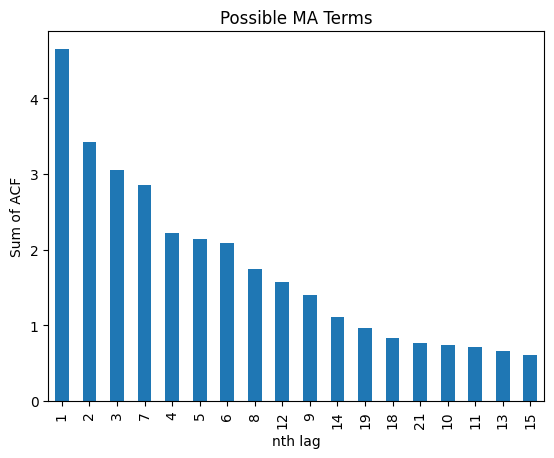

In [12]:
# visualize sums of values of significant spikes by nlags in ACF plots
df_sp_q.iloc[1:].T.sum().sort_values(ascending = False).plot(kind='bar', title='Possible MA Terms', xlabel='nth lag', ylabel='Sum of ACF')

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

# train ARIMA model with 3-fold CV and possible p, q terms inferred from the above graphs
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

p_values = [0, 1, 2, 7]
q_values = [1, 2, 3, 7]

best_score, best_param = float("inf"), None

for p in p_values:
    for q in q_values:
      all_mse = 0
      param = (p, 0, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 1) with mean MSE: 1643417.5682633205
params: (0, 0, 2) with mean MSE: 1623439.725968415
params: (0, 0, 3) with mean MSE: 1591112.9497886507
params: (0, 0, 7) with mean MSE: 1517079.234451683
params: (1, 0, 1) with mean MSE: 306499.86170766456
params: (1, 0, 2) with mean MSE: 272460.26428888657
params: (1, 0, 3) with mean MSE: 304978.5329644114
params: (1, 0, 7) with mean MSE: 424248.6749945281
params: (2, 0, 1) with mean MSE: 282693.2828077785
params: (2, 0, 2) with mean MSE: 270250.14245974773
params: (2, 0, 3) with mean MSE: 305099.7819400895
params: (2, 0, 7) with mean MSE: 1857542.9436629005
params: (7, 0, 1) with mean MSE: 225808.5848774511
params: (7, 0, 2) with mean MSE: 239146.26448959517
params: (7, 0, 3) with mean MSE: 252692.55998072648
params: (7, 0, 7) with mean MSE: 1017014.8681420424
Best ARIMA parameters: (7, 0, 1) with mean MSE: 225808.5848774511


-1.1553860068619906


<Axes: xlabel='date'>

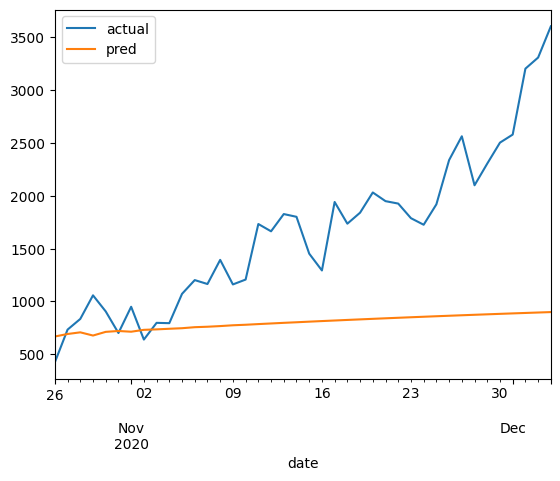

In [ ]:
model = ARIMA(train.incremental_cases, order=(7, 0, 1)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

p_values = [0, 1, 2, 7]
q_values = [1, 2, 3, 7]
P_values = range(0, 3)
Q_values = range(0, 3)

best_score, best_param = float("inf"), None

for p in p_values:
  for q in q_values:
    for P in P_values:
      for Q in Q_values:
        all_mse = 0
        param = (p, 0, q)
        s_param = (P, 0, Q, 30)
        for train_index, val_index in tscv.split(train):
          train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
          model = SARIMAX(train_data.incremental_cases, order = param, seasonal_order = s_param,
                          initialization ='approximate_diffuse').fit()
          mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
          all_mse = all_mse + mse
        print(f'params: {(param, s_param)} with mean MSE: {all_mse / 3}')
        if all_mse / 3 < best_score:
          best_score, best_param, = all_mse / 3, (param, s_param)

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: ((0, 0, 1), (0, 0, 0, 30)) with mean MSE: 151655.33285031698
params: ((0, 0, 1), (0, 0, 1, 30)) with mean MSE: 109396.89013075817
params: ((0, 0, 1), (0, 0, 2, 30)) with mean MSE: 110329.82751851525
params: ((0, 0, 1), (1, 0, 0, 30)) with mean MSE: 92228.6350123743
params: ((0, 0, 1), (1, 0, 1, 30)) with mean MSE: 87353.57571838074
params: ((0, 0, 1), (1, 0, 2, 30)) with mean MSE: 100115.39081705797
params: ((0, 0, 1), (2, 0, 0, 30)) with mean MSE: 121007.33685383697
params: ((0, 0, 1), (2, 0, 1, 30)) with mean MSE: 111976.07537361297
params: ((0, 0, 1), (2, 0, 2, 30)) with mean MSE: 307643.86109458003
params: ((0, 0, 2), (0, 0, 0, 30)) with mean MSE: 150405.99399683365
params: ((0, 0, 2), (0, 0, 1, 30)) with mean MSE: 107732.02761776734
params: ((0, 0, 2), (0, 0, 2, 30)) with mean MSE: 118058.77979342751
params: ((0, 0, 2), (1, 0, 0, 30)) with mean MSE: 116121.36104871969
params: ((0, 0, 2), (1, 0, 1, 30)) with mean MSE: 106909.97223192685
params: ((0, 0, 2), (1, 0, 2, 30)) wi

-3.1820408452101194


<Axes: xlabel='date'>

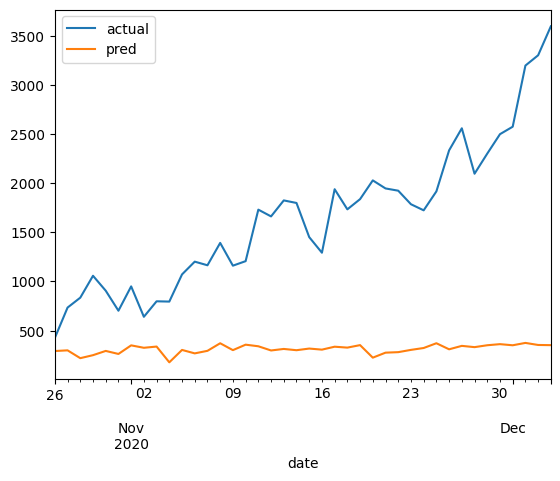

In [ ]:
model = SARIMAX(train_data.incremental_cases, order = (7, 0, 1), seasonal_order = (1, 0, 2, 30),
                          initialization ='approximate_diffuse').fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [20]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')

season_param = [(True, 30), (False, 1)]

best_score, best_param = float("inf"), None

for seasonal in season_param:
  all_mse = 0
  for train_index, val_index in tscv.split(train):
    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
    model = auto_arima(train_data.incremental_cases, start_p=0, start_q=1, max_p=7, max_q=7, d=0,
                       seasonal=seasonal[0], m=seasonal[1], error_action="ignore")
    mse = mean_squared_error(val_data.incremental_cases, model.predict(n_periods=val_data.shape[0]))
    all_mse = all_mse + mse
  print(f'params: {(max_p, max_q, seasonal)} with mean MSE: {all_mse / 3}')
  if all_mse / 3 < best_score:
    best_score, best_param = all_mse / 3, model

params: (0, 1, (True, 30)) with mean MSE: 46243.64811126407
params: (0, 1, (False, 1)) with mean MSE: 46243.64811126407


In [24]:
best_param

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 30),
      suppress_warnings=True, with_intercept=False)

-3.8795999237059675


<Axes: xlabel='date'>

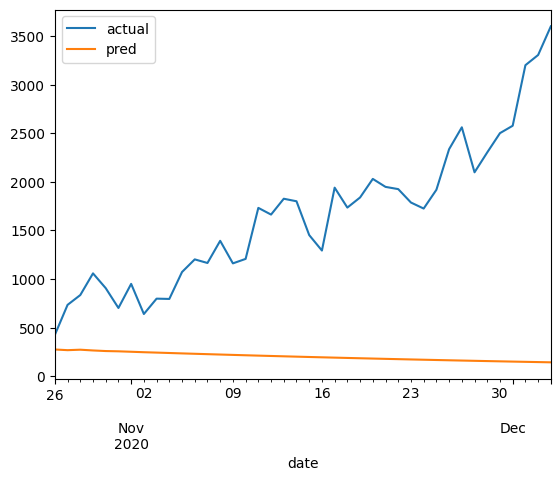

In [25]:
model = SARIMAX(train_data.incremental_cases, order = (3, 0, 0), seasonal_order = (0, 0, 0, 30)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

# END OF UPDATED CODE
### Below are sketch / experimental work

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

p_values = [0, 1, 2]
q_values = [1, 2, 3]

best_score, best_param = float("inf"), None

for p in p_values:
    for q in q_values:
      all_mse = 0
      param = (p, 0, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 1) with mean MSE: 1643417.5682633205
params: (0, 0, 2) with mean MSE: 1623439.725968415
params: (0, 0, 3) with mean MSE: 1591112.9497886507
params: (1, 0, 1) with mean MSE: 306499.86170766456
params: (1, 0, 2) with mean MSE: 272460.26428888657
params: (1, 0, 3) with mean MSE: 304978.5329644114
params: (2, 0, 1) with mean MSE: 282693.2828077785
params: (2, 0, 2) with mean MSE: 270250.14245974773
params: (2, 0, 3) with mean MSE: 305099.7819400895
Best ARIMA parameters: (2, 0, 2) with mean MSE: 270250.14245974773


-1.0982277117640407


<Axes: xlabel='date'>

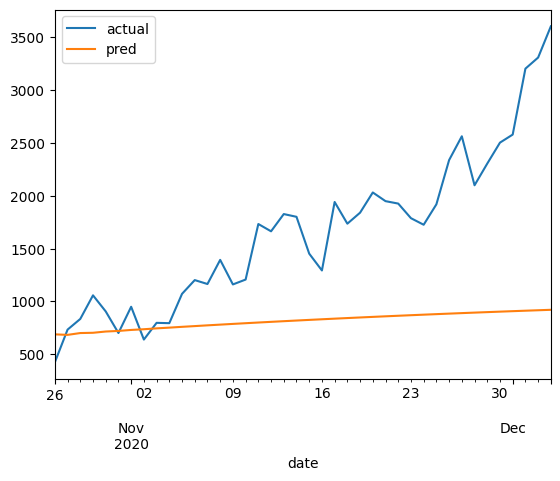

In [ ]:
model = ARIMA(train.incremental_cases, order=(2, 0, 2)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

p_values = [0, 1, 2, 7]
q_values = [1, 2, 3, 7]

best_score, best_param = float("inf"), None

for p in p_values:
    for q in q_values:
      all_mse = 0
      param = (p, 0, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 1) with mean MSE: 1643417.5682633205
params: (0, 0, 2) with mean MSE: 1623439.725968415
params: (0, 0, 3) with mean MSE: 1591112.9497886507
params: (0, 0, 7) with mean MSE: 1517079.234451683
params: (0, 1, 1) with mean MSE: 25456.257331185963
params: (0, 1, 2) with mean MSE: 25470.365403624808
params: (0, 1, 3) with mean MSE: 25838.272402862935
params: (0, 1, 7) with mean MSE: 24131.75251323333
params: (0, 2, 1) with mean MSE: 24768.931145272767
params: (0, 2, 2) with mean MSE: 21851.694884129116
params: (0, 2, 3) with mean MSE: 974977.7763812694
params: (0, 2, 7) with mean MSE: 1270672.2631633063
params: (1, 0, 1) with mean MSE: 306499.86170766456
params: (1, 0, 2) with mean MSE: 272460.26428888657
params: (1, 0, 3) with mean MSE: 304978.5329644114
params: (1, 0, 7) with mean MSE: 424248.6749945281
params: (1, 1, 1) with mean MSE: 25456.72356216829
params: (1, 1, 2) with mean MSE: 26361.76644680816
params: (1, 1, 3) with mean MSE: 26540.00135302014
params: (1, 1, 7) wit

-1.0211909342815346


<Axes: xlabel='date'>

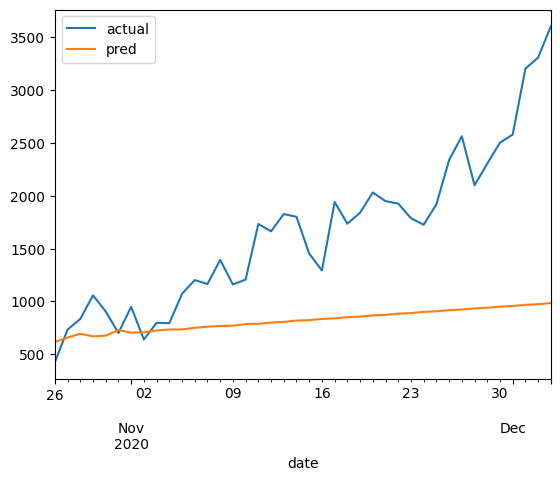

In [ ]:
model = ARIMA(train.incremental_cases, order=(7, 2, 2)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

p_values = [0, 1, 2, 3, 7]
d_values = [0]
q_values = [1, 2, 3, 7]

best_score, best_param = float("inf"), None

for p in p_values:
  for d in d_values:
    for q in q_values:
      all_mse = 0
      param = (p, d, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 1) with mean MSE: 1643417.5682633205
params: (0, 0, 2) with mean MSE: 1623439.725968415
params: (0, 0, 3) with mean MSE: 1591112.9497886507
params: (0, 0, 7) with mean MSE: 1517079.234451683
params: (1, 0, 1) with mean MSE: 306499.86170766456
params: (1, 0, 2) with mean MSE: 272460.26428888657
params: (1, 0, 3) with mean MSE: 304978.5329644114
params: (1, 0, 7) with mean MSE: 424248.6749945281
params: (2, 0, 1) with mean MSE: 282693.2828077785
params: (2, 0, 2) with mean MSE: 270250.14245974773
params: (2, 0, 3) with mean MSE: 305099.7819400895
params: (2, 0, 7) with mean MSE: 1857542.9436629005
params: (3, 0, 1) with mean MSE: 425445.9873016167
params: (3, 0, 2) with mean MSE: 307204.5927291887
params: (3, 0, 3) with mean MSE: 304731.91663330846
params: (3, 0, 7) with mean MSE: 1825885.7154289621
params: (7, 0, 1) with mean MSE: 225808.5848774511
params: (7, 0, 2) with mean MSE: 239146.26448959517
params: (7, 0, 3) with mean MSE: 252692.55998072648
params: (7, 0, 7) wit

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

p_values = [0, 1, 2, 3, 7]
d_values = [0, 1, 2]
q_values = [1, 2, 3, 7]
P_values = [0]
D_values = [0, 1, 2]
Q_values = [1]

param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))

best_score, best_param = float("inf"), None

for i in range(50):
  random_param = random.choice(param_grid)
  p, d, q, P, D, Q = random_param
  all_mse = 0
  param = (p, d, q)
  s_param = (P, D, Q, 30)
  for train_index, val_index in tscv.split(train):
    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
    model = SARIMAX(train_data.incremental_cases, order = param, seasonal_order = s_param,
                          initialization = 'approximate_diffuse').fit()
    mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
    all_mse = all_mse + mse
  print(f'params: {(param, s_param)} with mean MSE: {all_mse / 3}')
  if all_mse / 3 < best_score:
    best_score, best_param, = all_mse / 3, (param, s_param)

params: ((7, 2, 7), (0, 1, 1, 30)) with mean MSE: 4659138.1898864815
params: ((2, 2, 1), (0, 0, 1, 30)) with mean MSE: 1107509.3569490276
params: ((3, 2, 3), (0, 1, 1, 30)) with mean MSE: 1354648.2921681402
params: ((3, 2, 3), (0, 1, 1, 30)) with mean MSE: 1354648.2921681402
params: ((1, 2, 2), (0, 2, 1, 30)) with mean MSE: 2933516.803109285
params: ((2, 2, 1), (0, 1, 1, 30)) with mean MSE: 1008608.6862028952
params: ((2, 1, 1), (0, 1, 1, 30)) with mean MSE: 105459.56305442502
params: ((1, 0, 3), (0, 2, 1, 30)) with mean MSE: 144284.36120179427
params: ((2, 0, 7), (0, 2, 1, 30)) with mean MSE: 180688.68649018276
params: ((0, 1, 3), (0, 1, 1, 30)) with mean MSE: 93836.05043595251
params: ((3, 2, 2), (0, 0, 1, 30)) with mean MSE: 1052801.3887106108
params: ((2, 2, 7), (0, 1, 1, 30)) with mean MSE: 303787.24363328447
params: ((7, 2, 3), (0, 1, 1, 30)) with mean MSE: 1227248.7747644705
params: ((0, 2, 3), (0, 0, 1, 30)) with mean MSE: 87287.05610964632
params: ((3, 0, 3), (0, 1, 1, 30)) wi

In [ ]:
print(best_param, best_score)

((3, 1, 2), (0, 0, 1, 30)) 28956.474594675772


-1.6194163623899693


<Axes: xlabel='date'>

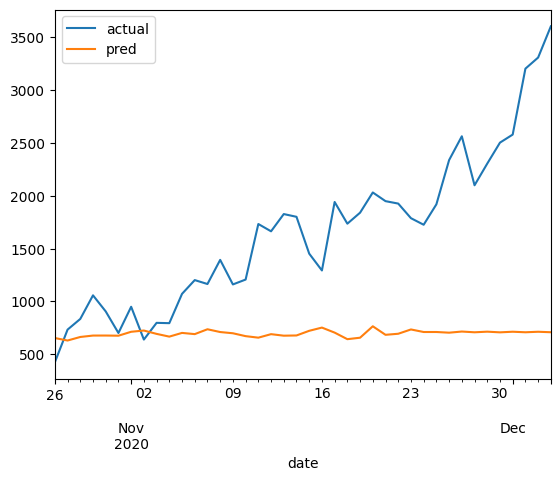

In [ ]:
model = SARIMAX(train.incremental_cases, order=(3, 1, 2), seasonal_order = (0, 0, 1, 30),
                initialization = 'approximate_diffuse').fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

p_values = range(0, 6)
q_values = range(0, 6)

best_score, best_param = float("inf"), None

for p in p_values:
  for q in q_values:
    all_mse = 0
    param = (p, 0, q)
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = ARIMA(train_data.incremental_cases, order = param).fit()
      mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0) with mean MSE: 1677275.5456228433
params: (0, 0, 1) with mean MSE: 1643417.5682633205
params: (0, 0, 2) with mean MSE: 1623439.725968415
params: (0, 0, 3) with mean MSE: 1591112.9497886507
params: (0, 0, 4) with mean MSE: 1570403.386984301
params: (0, 0, 5) with mean MSE: 1551584.371125634
params: (1, 0, 0) with mean MSE: 1057103.2396846667
params: (1, 0, 1) with mean MSE: 306499.86170766456
params: (1, 0, 2) with mean MSE: 272460.26428888657
params: (1, 0, 3) with mean MSE: 304978.5329644114
params: (1, 0, 4) with mean MSE: 310428.30220342975
params: (1, 0, 5) with mean MSE: 682872.904297592
params: (2, 0, 0) with mean MSE: 690793.6418463666
params: (2, 0, 1) with mean MSE: 282693.2828077785
params: (2, 0, 2) with mean MSE: 270250.14245974773
params: (2, 0, 3) with mean MSE: 305099.7819400895
params: (2, 0, 4) with mean MSE: 1264425.6674644528
params: (2, 0, 5) with mean MSE: 1523673.2222925604
params: (3, 0, 0) with mean MSE: 353977.6522758091
params: (3, 0, 1) with

-1.1810360225624867


<Axes: xlabel='date'>

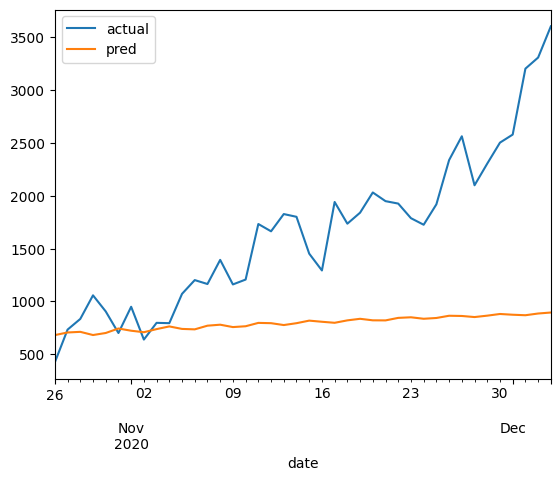

In [ ]:
model = ARIMA(train.incremental_cases, order=(5, 0, 5)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

p_values = range(4, 7)
q_values = range(4, 7)

best_score, best_param = float("inf"), None

for p in p_values:
  for q in q_values:
    all_mse = 0
    param = (p, 0, q)
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = ARIMA(train_data.incremental_cases, order = param).fit()
      mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (4, 0, 4) with mean MSE: 1578158.4129248348
params: (4, 0, 5) with mean MSE: 280634.6913578517
params: (4, 0, 6) with mean MSE: 299622.03252096614
params: (5, 0, 4) with mean MSE: 555029.2598244954
params: (5, 0, 5) with mean MSE: 249630.23827001403
params: (5, 0, 6) with mean MSE: 1467056.7870011209
params: (6, 0, 4) with mean MSE: 1244338.5291101746
params: (6, 0, 5) with mean MSE: 2197310.7957979557
params: (6, 0, 6) with mean MSE: 259359.6236077999
Best ARIMA parameters: (5, 0, 5) with mean MSE: 249630.23827001403


In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

P_values = range(0, 6)
Q_values = range(0, 6)

best_score, best_param = float("inf"), None

for P in p_values:
  for Q in q_values:
    all_mse = 0
    param = (P, 0, Q, 12)
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = SARIMAX(train_data.incremental_cases, order = (5, 0, 5), seasonal_order = (P, 0, Q, 12)).fit()
      mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0, 12) with mean MSE: 71238.44581988598
params: (0, 0, 1, 12) with mean MSE: 81487.93636140546
params: (0, 0, 2, 12) with mean MSE: 207241.3630084128
params: (0, 0, 3, 12) with mean MSE: 90324.16010195886
params: (0, 0, 4, 12) with mean MSE: 144169.1228792698
params: (0, 0, 5, 12) with mean MSE: 78990.93717718714
params: (1, 0, 0, 12) with mean MSE: 75818.32462527814
params: (1, 0, 1, 12) with mean MSE: 75254.79409432561
params: (1, 0, 2, 12) with mean MSE: 94727.55515197135
params: (1, 0, 3, 12) with mean MSE: 144304.26229790438
params: (1, 0, 4, 12) with mean MSE: 140160.25204319638
params: (1, 0, 5, 12) with mean MSE: 144476.60751071354
params: (2, 0, 0, 12) with mean MSE: 126607.94746157515
params: (2, 0, 1, 12) with mean MSE: 51238.71003424972
params: (2, 0, 2, 12) with mean MSE: 50142.27937685252
params: (2, 0, 3, 12) with mean MSE: 125924.46219536813
params: (2, 0, 4, 12) with mean MSE: 137951.86976518264
params: (2, 0, 5, 12) with mean MSE: 139861.7202802697
para

-3.6439216580999485


<Axes: xlabel='date'>

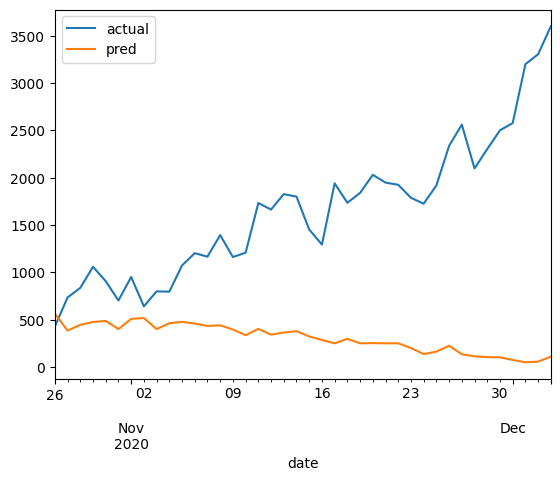

In [ ]:
model = SARIMAX(train.incremental_cases, order=(5, 0, 5), seasonal_order = (3, 0, 3, 12)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

p_values = range(0, 6)
q_values = range(0, 6)
P_values = range(0, 6)
Q_values = range(0, 6)

best_score, best_param = float("inf"), None

for p in p_values:
  for q in q_values:
    for P in P_values:
      for Q in Q_values:
        all_mse = 0
        param = (p, 0, q)
        s_param = (P, 0, Q, 12)
        for train_index, val_index in tscv.split(train):
          train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
          model = SARIMAX(train_data.incremental_cases, order = param, seasonal_order = s_param,
                          initialization ='approximate_diffuse').fit()
          mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
          all_mse = all_mse + mse
        print(f'params: {(param, s_param)} with mean MSE: {all_mse / 3}')
        if all_mse / 3 < best_score:
          best_score, best_param, = all_mse / 3, (param, s_param)

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: ((0, 0, 0), (0, 0, 0, 12)) with mean MSE: 153476.31666666668
params: ((0, 0, 0), (0, 0, 1, 12)) with mean MSE: 154130.8552946828
params: ((0, 0, 0), (0, 0, 2, 12)) with mean MSE: 541466.2670683713
params: ((0, 0, 0), (0, 0, 3, 12)) with mean MSE: 200639.72394084328
params: ((0, 0, 0), (0, 0, 4, 12)) with mean MSE: 418766.4986026164
params: ((0, 0, 0), (0, 0, 5, 12)) with mean MSE: 152358.5489278379
params: ((0, 0, 0), (1, 0, 0, 12)) with mean MSE: 57338.31480641358
params: ((0, 0, 0), (1, 0, 1, 12)) with mean MSE: 74615.07480681494
params: ((0, 0, 0), (1, 0, 2, 12)) with mean MSE: 374151.27715054114
params: ((0, 0, 0), (1, 0, 3, 12)) with mean MSE: 263933.97580357053
params: ((0, 0, 0), (1, 0, 4, 12)) with mean MSE: 134391.75216165505
params: ((0, 0, 0), (1, 0, 5, 12)) with mean MSE: 295975.12881867395
params: ((0, 0, 0), (2, 0, 0, 12)) with mean MSE: 95031.85125373518
params: ((0, 0, 0), (2, 0, 1, 12)) with mean MSE: 296907.04107341316
params: ((0, 0, 0), (2, 0, 2, 12)) with m

KeyboardInterrupt: 

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

p_values = range(0, 6)
q_values = range(0, 6)
P_values = range(0, 6)
Q_values = range(0, 6)

param_grid = list(itertools.product(p_values, q_values, P_values, Q_values))

best_score, best_param = float("inf"), None

for i in range(50):
  random_param = random.choice(param_grid)
  p, q, P, Q = random_param
  all_mse = 0
  for train_index, val_index in tscv.split(train):
    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
    model = SARIMAX(train_data, order=(p, 0, q), seasonal_order=(P, 0, Q, 12),
                        initialization ='approximate_diffuse').fit(disp = False)
    mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
    all_mse = all_mse + mse
  print(f'params: {(p, 0, q, P, 0, Q, 12)} with mean MSE: {all_mse / 3}')
  if all_mse / 3 < best_score:
    best_score, best_param = all_mse / 3, (p, 0, q, P, 0, Q, 12)

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (3, 0, 3, 1, 0, 1, 12) with mean MSE: 108832.4176099787
params: (5, 0, 0, 4, 0, 4, 12) with mean MSE: 65898.31827519102
params: (1, 0, 1, 5, 0, 3, 12) with mean MSE: 75067.28870559977
params: (3, 0, 1, 5, 0, 5, 12) with mean MSE: 34571.19882512308
params: (2, 0, 3, 4, 0, 0, 12) with mean MSE: 62493.061846527235
params: (1, 0, 3, 2, 0, 3, 12) with mean MSE: 112142.0754964215
params: (0, 0, 4, 2, 0, 3, 12) with mean MSE: 163959.5705985509
params: (0, 0, 0, 2, 0, 5, 12) with mean MSE: 132040.41963867008
params: (4, 0, 1, 3, 0, 2, 12) with mean MSE: 56712.114994759206
params: (5, 0, 2, 4, 0, 4, 12) with mean MSE: 61623.72287557571
params: (1, 0, 0, 1, 0, 3, 12) with mean MSE: 107009.3218561015
params: (2, 0, 2, 3, 0, 2, 12) with mean MSE: 234263.2088341238
params: (4, 0, 1, 1, 0, 1, 12) with mean MSE: 214418.91122287782
params: (0, 0, 0, 0, 0, 2, 12) with mean MSE: 541466.2670683713
params: (5, 0, 0, 1, 0, 1, 12) with mean MSE: 94962.33441625988
params: (5, 0, 5, 1, 0, 4, 12) with 

-2.02238990934298


<Axes: xlabel='date'>

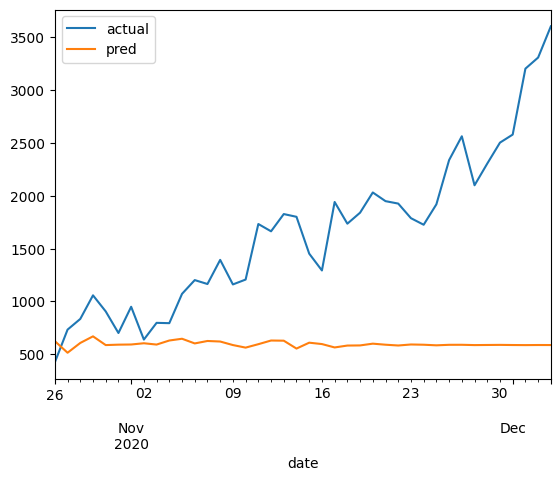

In [ ]:
model = SARIMAX(train.incremental_cases, order=(5, 0, 4), seasonal_order = (0, 0, 3, 12),
                initialization ='approximate_diffuse').fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

p_values = range(0, 6)
q_values = range(0, 6)
P_values = range(0, 6)
Q_values = range(0, 6)

param_grid = list(itertools.product(p_values, q_values, P_values, Q_values))

best_score, best_param = float("inf"), None

for i in range(100):
  random_param = random.choice(param_grid)
  p, q, P, Q = random_param
  all_mse = 0
  for train_index, val_index in tscv.split(train):
    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
    model = SARIMAX(train_data, order=(p, 0, q), seasonal_order=(P, 0, Q, 12),
                        initialization ='approximate_diffuse').fit(disp = False)
    mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
    all_mse = all_mse + mse
  print(f'params: {(p, 0, q, P, 0, Q, 12)} with mean MSE: {all_mse / 3}')
  if all_mse / 3 < best_score:
    best_score, best_param = all_mse / 3, (p, 0, q, P, 0, Q, 12)

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 1, 4, 0, 5, 12) with mean MSE: 168160.9787464103
params: (0, 0, 1, 0, 0, 0, 12) with mean MSE: 151655.33285031698
params: (3, 0, 3, 5, 0, 0, 12) with mean MSE: 34357.305704488834
params: (0, 0, 5, 4, 0, 1, 12) with mean MSE: 109003.40837007586
params: (4, 0, 4, 3, 0, 4, 12) with mean MSE: 31296.502661408143
params: (3, 0, 3, 0, 0, 1, 12) with mean MSE: 34534.088752027004
params: (3, 0, 2, 3, 0, 4, 12) with mean MSE: 146022.35268694875
params: (1, 0, 1, 1, 0, 2, 12) with mean MSE: 197707.39830252776
params: (0, 0, 3, 4, 0, 0, 12) with mean MSE: 39822.50933011651
params: (5, 0, 4, 2, 0, 5, 12) with mean MSE: 32599.15201873891
params: (3, 0, 2, 4, 0, 3, 12) with mean MSE: 27157.538074025902
params: (3, 0, 4, 3, 0, 1, 12) with mean MSE: 122711.08666759457
params: (5, 0, 3, 0, 0, 5, 12) with mean MSE: 58503.83368125132
params: (1, 0, 1, 0, 0, 1, 12) with mean MSE: 41428.98401776219
params: (4, 0, 0, 2, 0, 1, 12) with mean MSE: 189749.41713990926
params: (1, 0, 4, 1, 0, 1, 12)

-1.8372460302636688


<Axes: xlabel='date'>

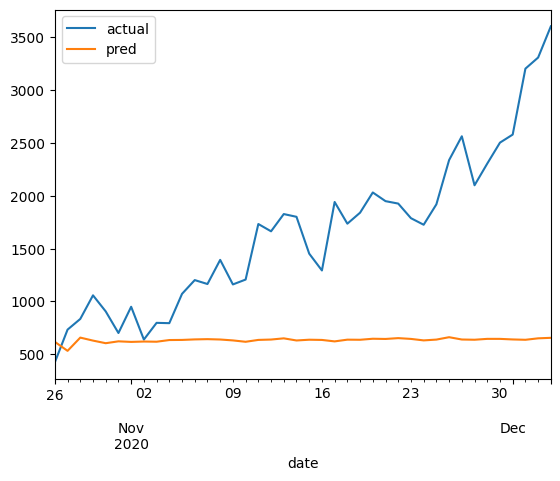

In [ ]:
model = SARIMAX(train.incremental_cases, order=(4, 0, 3), seasonal_order = (4, 0, 1, 12),
                initialization ='approximate_diffuse').fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
best_score, best_param = float("inf"), None

for P in range(1, 4):
  for D in range(0, 4):
    for Q in range(1, 4):
      param = (P, D, Q, 12)
      # validate on the last 40 entires of train data
      train_data, val_data = train.iloc[:-40], train.iloc[-40:]
      model = SARIMAX(train_data.incremental_cases, order = (2, 3, 1),
                      seasonal_order = param).fit(disp=False)
      mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=40))
      print(f'params: {param} with MSE: {mse}')
      if mse < best_score:
        best_score, best_param = mse, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (1, 0, 1, 12) with MSE: 11323.652423423528
params: (1, 0, 2, 12) with MSE: 138119.86660977872
params: (1, 0, 3, 12) with MSE: 12768.555888643066
params: (1, 1, 1, 12) with MSE: 105499.98702228977
params: (1, 1, 2, 12) with MSE: 56208.012722276406
params: (1, 1, 3, 12) with MSE: 727843.3732523348
params: (1, 2, 1, 12) with MSE: 11287081.52821813
params: (1, 2, 2, 12) with MSE: 6002476.404046221
params: (1, 2, 3, 12) with MSE: 5619986.835953555
params: (1, 3, 1, 12) with MSE: 403477207823.6981
params: (1, 3, 2, 12) with MSE: 358004353156.7121
params: (1, 3, 3, 12) with MSE: 894096758489.4656
params: (2, 0, 1, 12) with MSE: 16582.134238282008
params: (2, 0, 2, 12) with MSE: 132483.28126281602
params: (2, 0, 3, 12) with MSE: 26831.40462424704
params: (2, 1, 1, 12) with MSE: 1786109.4941130895
params: (2, 1, 2, 12) with MSE: 228767.4622061905
params: (2, 1, 3, 12) with MSE: 334649.55850451
params: (2, 2, 1, 12) with MSE: 685775.0477038381
params: (2, 2, 2, 12) with MSE: 3905782.6197

0.622809909857793


<Axes: xlabel='date'>

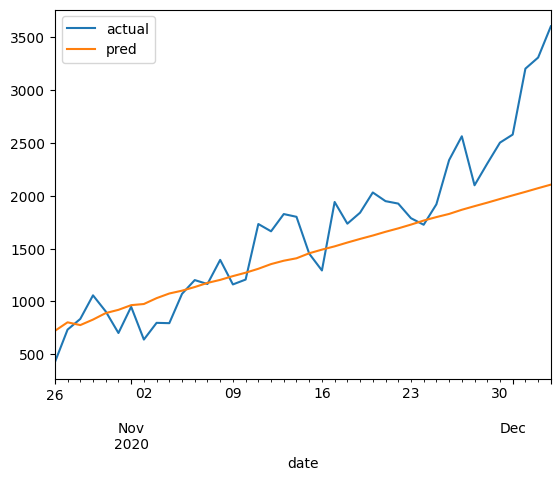

In [ ]:
model = SARIMAX(train.incremental_cases, order = (2, 3, 1), seasonal_order = (1, 0, 1, 12)).fit(disp=False)
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

0.622809909857793


<Axes: xlabel='date'>

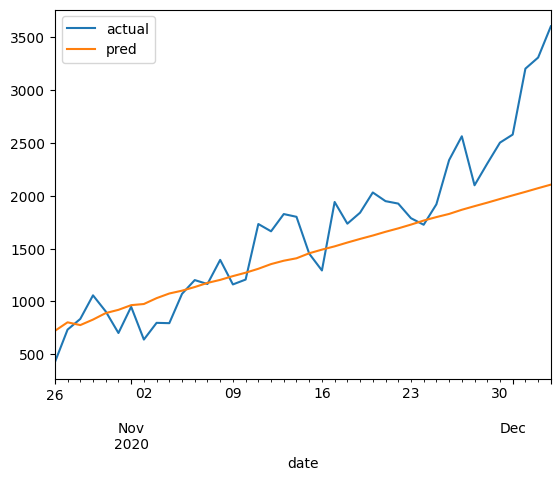

In [ ]:
model = SARIMAX(train.incremental_cases, order = (2, 3, 1),
                      seasonal_order = (1, 0, 1, 12)).fit(disp=False)
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
best_score, best_param = float("inf"), None

for p in range(1, 6):
  for d in range(0, 4):
    for q in range(1, 6):
      param = (p, d, q)
      # validate on the last 40 entires of train data
      train_data, val_data = train.iloc[:-40], train.iloc[-40:]
      model = ARIMA(train_data.incremental_cases, order = param).fit()
      mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=40))
      print(f'params: {param} with MSE: {mse}')
      if mse < best_score:
        best_score, best_param = mse, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (1, 0, 1) with MSE: 29495.077855749878
params: (1, 0, 2) with MSE: 23811.916233121286
params: (1, 0, 3) with MSE: 28958.46219793312
params: (1, 0, 4) with MSE: 28410.57003146766
params: (1, 0, 5) with MSE: 21647.309744769813
params: (1, 1, 1) with MSE: 67634.45210699156
params: (1, 1, 2) with MSE: 70035.79208876101
params: (1, 1, 3) with MSE: 70189.44444654568
params: (1, 1, 4) with MSE: 359864.78087931685
params: (1, 1, 5) with MSE: 253690.9913318315
params: (1, 2, 1) with MSE: 47998.83679755243
params: (1, 2, 2) with MSE: 45858.69958580078
params: (1, 2, 3) with MSE: 143728.01225990857
params: (1, 2, 4) with MSE: 172174.44009381713
params: (1, 2, 5) with MSE: 65981.74248209533
params: (1, 3, 1) with MSE: 403627.62563688477
params: (1, 3, 2) with MSE: 28850.756974071184
params: (1, 3, 3) with MSE: 1902340.5211098485
params: (1, 3, 4) with MSE: 13752.887507737338
params: (1, 3, 5) with MSE: 16652.247974628972
params: (2, 0, 1) with MSE: 25325.18439819698
params: (2, 0, 2) with 

0.6248273078440358


<Axes: xlabel='date'>

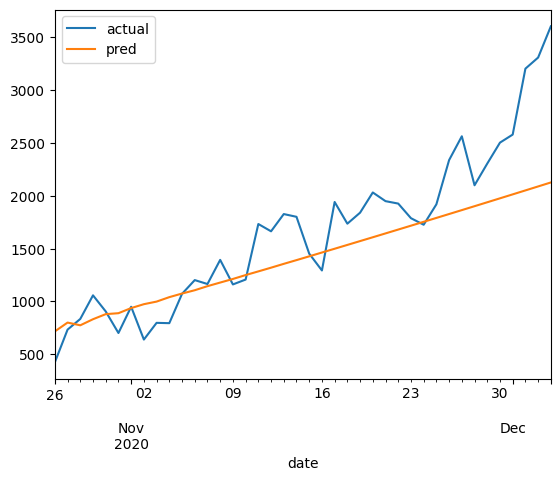

In [ ]:
model = ARIMA(train.incremental_cases, order=(2, 3, 1)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)

best_score, best_param = float("inf"), None

for p in p_values:
  for d in d_values:
    for q in q_values:
      all_mse = 0
      param = (p, d, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0) with mean MSE: 1677275.5456228433
params: (0, 0, 1) with mean MSE: 1643417.5682633205
params: (0, 0, 2) with mean MSE: 1623439.725968415
params: (0, 0, 3) with mean MSE: 1591112.9497886507
params: (0, 0, 4) with mean MSE: 1570403.386984301
params: (0, 0, 5) with mean MSE: 1551584.371125634
params: (0, 0, 6) with mean MSE: 1534754.6006170975
params: (0, 1, 0) with mean MSE: 23296.95
params: (0, 1, 1) with mean MSE: 25456.257331185963
params: (0, 1, 2) with mean MSE: 25470.365403624808
params: (0, 1, 3) with mean MSE: 25838.272402862935
params: (0, 1, 4) with mean MSE: 26539.627132114645
params: (0, 1, 5) with mean MSE: 25658.563088539715
params: (0, 1, 6) with mean MSE: 24150.28247211897
params: (0, 2, 0) with mean MSE: 353819.9500000002
params: (0, 2, 1) with mean MSE: 24768.931145272767
params: (0, 2, 2) with mean MSE: 21851.694884129116
params: (0, 2, 3) with mean MSE: 974977.7763812694
params: (0, 2, 4) with mean MSE: 97855.29257906131
params: (0, 2, 5) with mean M

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)

best_score, best_param = float("inf"), None

for p in p_values:
  for d in d_values:
    for q in q_values:
      all_mse = 0
      param = (p, d, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0) with mean MSE: 1677275.5456228433
params: (0, 0, 1) with mean MSE: 1643417.5682633205
params: (0, 0, 2) with mean MSE: 1623439.725968415
params: (0, 0, 3) with mean MSE: 1591112.9497886507
params: (0, 1, 0) with mean MSE: 23296.95
params: (0, 1, 1) with mean MSE: 25456.257331185963
params: (0, 1, 2) with mean MSE: 25470.365403624808
params: (0, 1, 3) with mean MSE: 25838.272402862935
params: (0, 2, 0) with mean MSE: 353819.9500000002
params: (0, 2, 1) with mean MSE: 24768.931145272767
params: (0, 2, 2) with mean MSE: 21851.694884129116
params: (0, 2, 3) with mean MSE: 974977.7763812694
params: (0, 3, 0) with mean MSE: 185456822.70000044
params: (0, 3, 1) with mean MSE: 427421.16215850384
params: (0, 3, 2) with mean MSE: 622869.9140518536
params: (0, 3, 3) with mean MSE: 2877085.9242163445
params: (1, 0, 0) with mean MSE: 1057103.2396846667
params: (1, 0, 1) with mean MSE: 306499.86170766456
params: (1, 0, 2) with mean MSE: 272460.26428888657
params: (1, 0, 3) with mea

-0.8705180286927419


<Axes: xlabel='date'>

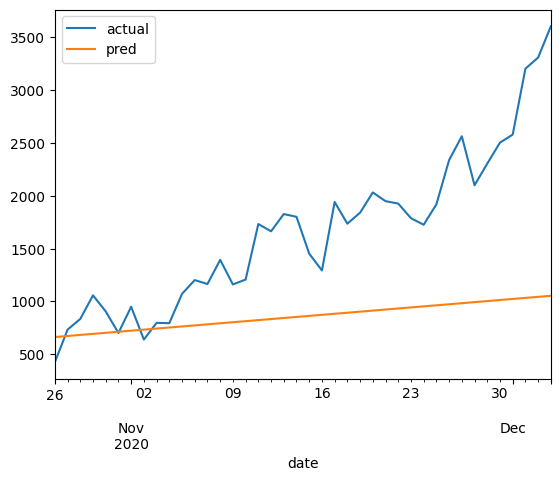

In [ ]:
model = ARIMA(train.incremental_cases, order=(0, 2, 2)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

-1.698082779197959


<Axes: xlabel='date'>

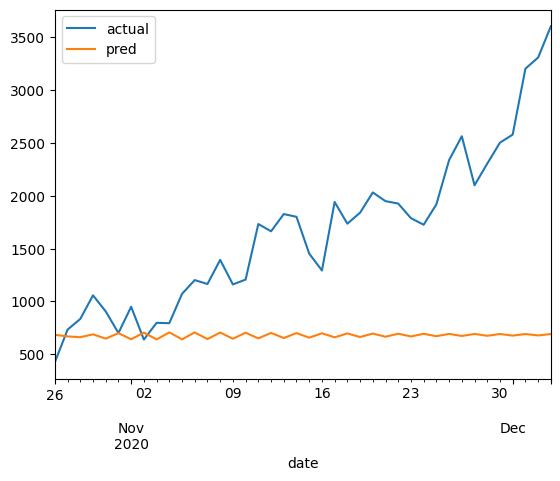

In [ ]:
model = ARIMA(train.incremental_cases, order=(4, 1, 4)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

P_values = range(0, 3)
D_values = range(0, 3)
Q_values = range(0, 3)

for P in P_values:
  for D in D_values:
    for Q in Q_values:
      all_mse = 0
      param = (P, D, Q, 12)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = SARIMAX(train_data.incremental_cases, order = (0, 2, 2), seasonal_order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0, 12) with mean MSE: 21851.694884129116
params: (0, 0, 1, 12) with mean MSE: 21940.582257834667
params: (0, 0, 2, 12) with mean MSE: 26449.477363557064
params: (0, 1, 0, 12) with mean MSE: 254940.4525659506
params: (0, 1, 1, 12) with mean MSE: 1881641.8112798326
params: (0, 1, 2, 12) with mean MSE: 2301394.725430383
params: (0, 2, 0, 12) with mean MSE: 22083916.84835884
params: (0, 2, 1, 12) with mean MSE: 3315998.851316316
params: (0, 2, 2, 12) with mean MSE: 11576909.61165152
params: (1, 0, 0, 12) with mean MSE: 21900.483756476737
params: (1, 0, 1, 12) with mean MSE: 21693.83254141609
params: (1, 0, 2, 12) with mean MSE: 29693.273241350264
params: (1, 1, 0, 12) with mean MSE: 1921594.7729369448
params: (1, 1, 1, 12) with mean MSE: 1282193.7148674196
params: (1, 1, 2, 12) with mean MSE: 1295698.5910765205
params: (1, 2, 0, 12) with mean MSE: 2803733.7891609706
params: (1, 2, 1, 12) with mean MSE: 12848397.216387643
params: (1, 2, 2, 12) with mean MSE: 3514699.723567552

-0.8703790666015576


<Axes: xlabel='date'>

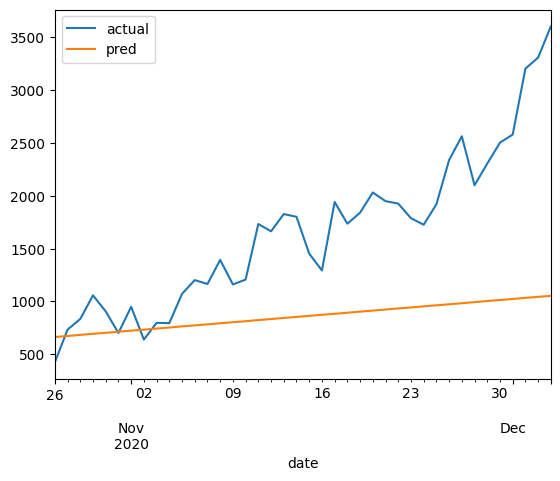

In [ ]:
model = SARIMAX(train.incremental_cases, order = (0, 2, 2), seasonal_order = (1, 0, 1, 12)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
import itertools
import random
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
P_values = range(0, 6)
D_values = range(0, 3)
Q_values = range(0, 6)

param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))

best_score, best_param = float("inf"), None

for i in range(100):
    random_param = random.choice(param_grid)
    p, d, q, P, D, Q = random_param
    for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, 12)).fit(disp = False)
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
        print(f'params: {(p, d, q, P, D, Q, 12)} with mean MSE: {all_mse / 3}')
        if all_mse / 3 < best_score:
          best_score, best_param = all_mse / 3, (p, d, q, P, D, Q, 12)

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')


params: (3, 1, 3, 4, 2, 4, 12) with mean MSE: 406455.786664864
params: (3, 1, 3, 4, 2, 4, 12) with mean MSE: 432061.59687943803
params: (3, 1, 3, 4, 2, 4, 12) with mean MSE: 582905.4376569238
params: (4, 0, 0, 1, 1, 2, 12) with mean MSE: 598887.3433124213
params: (4, 0, 0, 1, 1, 2, 12) with mean MSE: 640638.727549031
params: (4, 0, 0, 1, 1, 2, 12) with mean MSE: 652052.3144111686
params: (2, 1, 0, 1, 0, 3, 12) with mean MSE: 653504.7406114299
params: (2, 1, 0, 1, 0, 3, 12) with mean MSE: 654654.2546895402
params: (2, 1, 0, 1, 0, 3, 12) with mean MSE: 677497.7217029008
params: (5, 2, 3, 2, 1, 0, 12) with mean MSE: 696006.2342957825
params: (5, 2, 3, 2, 1, 0, 12) with mean MSE: 825749.1954127358
params: (5, 2, 3, 2, 1, 0, 12) with mean MSE: 962325.0916513223
params: (2, 1, 5, 3, 2, 4, 12) with mean MSE: 1030368.5352633931
params: (2, 1, 5, 3, 2, 4, 12) with mean MSE: 1068488.3786670025
params: (2, 1, 5, 3, 2, 4, 12) with mean MSE: 1207502.8968590423
params: (5, 0, 3, 4, 0, 2, 12) with me

LinAlgError: LU decomposition error.

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)

P_values = range(0, 7)
D_values = range(0, 3)
Q_values = range(0, 7)

best_score, best_param = float("inf"), None

for p in p_values:
  for d in d_values:
    for q in q_values:
      for P in P_values:
        for D in D_values:
          for Q in Q_values:
            all_mse = 0
            param = (p, d, q, P, D, Q)
            for train_index,
      all_mse = 0
      param = (p, d, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0) with mean MSE: 1677275.5456228433
params: (0, 0, 1) with mean MSE: 1643417.5682633205
params: (0, 0, 2) with mean MSE: 1623439.725968415
params: (0, 0, 3) with mean MSE: 1591112.9497886507
params: (0, 0, 4) with mean MSE: 1570403.386984301
params: (0, 0, 5) with mean MSE: 1551584.371125634
params: (1, 0, 0) with mean MSE: 1057103.2396846667
params: (1, 0, 1) with mean MSE: 306499.86170766456
params: (1, 0, 2) with mean MSE: 272460.26428888657
params: (1, 0, 3) with mean MSE: 304978.5329644114
params: (1, 0, 4) with mean MSE: 310428.30220342975
params: (1, 0, 5) with mean MSE: 682872.904297592
params: (2, 0, 0) with mean MSE: 690793.6418463666
params: (2, 0, 1) with mean MSE: 282693.2828077785
params: (2, 0, 2) with mean MSE: 270250.14245974773
params: (2, 0, 3) with mean MSE: 305099.7819400895
params: (2, 0, 4) with mean MSE: 1264425.6674644528
params: (2, 0, 5) with mean MSE: 1523673.2222925604
params: (3, 0, 0) with mean MSE: 353977.6522758091
params: (3, 0, 1) with

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)

P_values =


best_score, best_param = float("inf"), None

for p in p_values:
  for d in d_values:
    for q in q_values:
      all_mse = 0
      param = (p, d, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

best_score, best_param = float("inf"), None

for p in p_values:
  for d in d_values:
    for q in q_values:
      all_mse = 0
      param = (p, d, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0) with mean MSE: 1677275.5456228433
params: (0, 0, 1) with mean MSE: 1643417.5682633205
params: (0, 0, 2) with mean MSE: 1623439.725968415
params: (0, 0, 3) with mean MSE: 1591112.9497886507
params: (0, 0, 4) with mean MSE: 1570403.386984301
params: (0, 0, 5) with mean MSE: 1551584.371125634
params: (0, 1, 0) with mean MSE: 23296.95
params: (0, 1, 1) with mean MSE: 25456.257331185963
params: (0, 1, 2) with mean MSE: 25470.365403624808
params: (0, 1, 3) with mean MSE: 25838.272402862935
params: (0, 1, 4) with mean MSE: 26539.627132114645
params: (0, 1, 5) with mean MSE: 25658.563088539715
params: (0, 2, 0) with mean MSE: 353819.9500000002
params: (0, 2, 1) with mean MSE: 24768.931145272767
params: (0, 2, 2) with mean MSE: 21851.694884129116
params: (0, 2, 3) with mean MSE: 974977.7763812694
params: (0, 2, 4) with mean MSE: 97855.29257906131
params: (0, 2, 5) with mean MSE: 943508.7832169444
params: (1, 0, 0) with mean MSE: 1057103.2396846667
params: (1, 0, 1) with mean M

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

P_values = [0, 1, 5]
D_values = [0, 1, 2]
Q_values = [0, 1, 5]

best_score, best_param = float("inf"), None

for P in P_values:
  for D in D_values:
    for Q in Q_values:
      all_mse = 0
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        param = (P, D, Q, 12)
        model = SARIMAX(train_data.incremental_cases, order = (5, 1, 10),
                      seasonal_order = param).fit(disp=False)
        pred = model.forecast(steps=val_data.shape[0])
        mse = mean_squared_error(val_data.incremental_cases, pred)
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0, 12) with mean MSE: 17831.55754551371
params: (0, 0, 1, 12) with mean MSE: 18446.380565757634
params: (0, 0, 5, 12) with mean MSE: 601266.1517290241
params: (0, 1, 0, 12) with mean MSE: 154352.3090748214
params: (0, 1, 1, 12) with mean MSE: 105459.49381268793
params: (0, 1, 5, 12) with mean MSE: 5191302.878434997
params: (0, 2, 0, 12) with mean MSE: 529834.3527396267
params: (0, 2, 1, 12) with mean MSE: 652369.1257755848
params: (0, 2, 5, 12) with mean MSE: 4252373.2654622225
params: (1, 0, 0, 12) with mean MSE: 18680.415835058462
params: (1, 0, 1, 12) with mean MSE: 20378.694215112384
params: (1, 0, 5, 12) with mean MSE: 1072883.2884341432
params: (1, 1, 0, 12) with mean MSE: 35207.79182384711
params: (1, 1, 1, 12) with mean MSE: 213214.26367250012
params: (1, 1, 5, 12) with mean MSE: 396221.241163617
params: (1, 2, 0, 12) with mean MSE: 151921.7538781785
params: (1, 2, 1, 12) with mean MSE: 851371.7790981657
params: (1, 2, 5, 12) with mean MSE: 2519405.3635693775
par

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

p_values = [0, 1, 5]
d_values = [0, 1, 2]
q_values = [0, 1, 5]

best_score, best_param = float("inf"), None

for p in p_values:
  for d in d_values:
    for q in q_values:
      all_mse = 0
      param = (p, d, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0) with mean MSE: 1677275.5456228433
params: (0, 0, 1) with mean MSE: 1643417.5682633205
params: (0, 0, 5) with mean MSE: 1551584.371125634
params: (0, 1, 0) with mean MSE: 23296.95
params: (0, 1, 1) with mean MSE: 25456.257331185963
params: (0, 1, 5) with mean MSE: 25658.563088539715
params: (0, 2, 0) with mean MSE: 353819.9500000002
params: (0, 2, 1) with mean MSE: 24768.931145272767
params: (0, 2, 5) with mean MSE: 943508.7832169444
params: (1, 0, 0) with mean MSE: 1057103.2396846667
params: (1, 0, 1) with mean MSE: 306499.86170766456
params: (1, 0, 5) with mean MSE: 682872.904297592
params: (1, 1, 0) with mean MSE: 24473.992401025997
params: (1, 1, 1) with mean MSE: 25456.72356216829
params: (1, 1, 5) with mean MSE: 157721.8721904675
params: (1, 2, 0) with mean MSE: 164016.81038918608
params: (1, 2, 1) with mean MSE: 25854.782832962115
params: (1, 2, 5) with mean MSE: 944332.8523890101
params: (5, 0, 0) with mean MSE: 305667.39559687773
params: (5, 0, 1) with mean MS

-0.8789821548746832


<Axes: xlabel='date'>

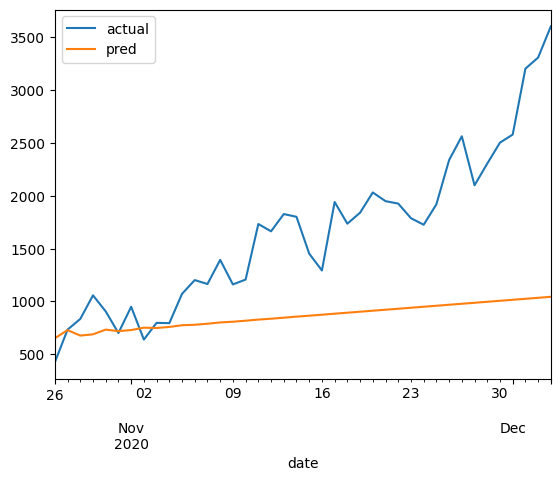

In [ ]:
model = ARIMA(train.incremental_cases, order=(5, 2, 1)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

P_values = [0, 1, 5, 10]
Q_values = [0, 1, 5, 10]

best_score, best_param = float("inf"), None

for P in P_values:
  for Q in Q_values:
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      param = (P, 2, Q, 12)
      model = SARIMAX(train_data.incremental_cases, order = (5, 2, 0),
                      seasonal_order = param, initialization ='approximate_diffuse').fit(disp=False)
      pred = model.forecast(steps=val_data.shape[0])
      mse = mean_squared_error(val_data.incremental_cases, pred)
      all_mse = all_mse + mse
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

Best ARIMA parameters: (5, 2, 1, 12) with mean MSE: 684098.4460516095


-3.589664260756078


<Axes: xlabel='date'>

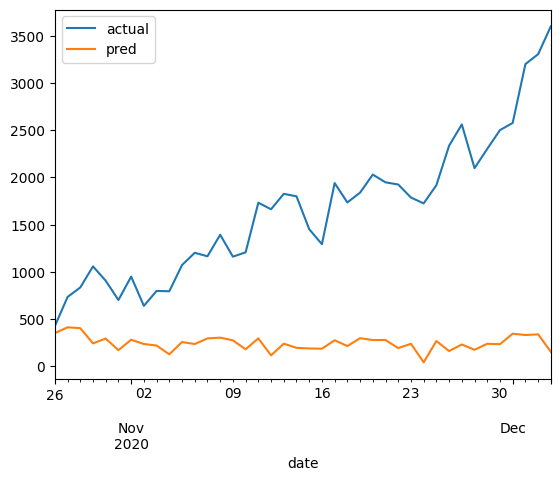

In [ ]:
model = SARIMAX(train_data.incremental_cases, order = (5, 2, 0),
                      seasonal_order = (5, 2, 1, 12), initialization ='approximate_diffuse').fit(disp=False)
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

-1.2726216966815578


<Axes: xlabel='date'>

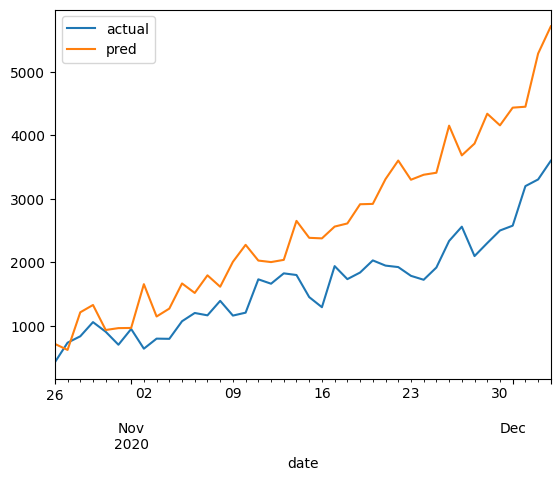

In [ ]:
model = SARIMAX(train.incremental_cases, order = (5, 2, 0),
                      seasonal_order = (5, 2, 1, 12), initialization ='approximate_diffuse').fit(disp=False)
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

0.7619629034769115


<Axes: xlabel='date'>

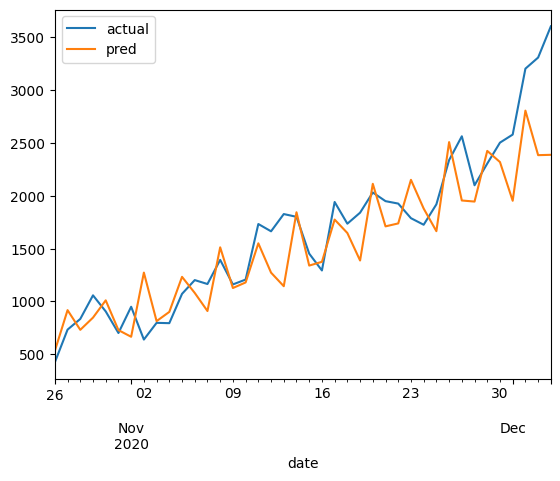

In [ ]:
model = SARIMAX(train.incremental_cases, order = (5, 2, 0),
                      seasonal_order = (5, 1, 1, 12), initialization ='approximate_diffuse').fit(disp=False)
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

P_values = [0, 1, 5]
D_values = [0, 1, 2]
Q_values = [0, 1, 5]

best_score, best_param = float("inf"), None

for P in P_values:
  for D in D_values:
    for Q in Q_values:
      all_mse = 0
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        param = (P, D, Q, 12)
        model = SARIMAX(train_data.incremental_cases, order = (5, 2, 0),
                      seasonal_order = param, initialization ='approximate_diffuse').fit(disp=False)
        pred = model.forecast(steps=val_data.shape[0])
        mse = mean_squared_error(val_data.incremental_cases, pred)
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0, 12) with mean MSE: 85449.97184891593
params: (0, 0, 1, 12) with mean MSE: 71520.28572355537
params: (0, 0, 5, 12) with mean MSE: 151772.984880797
params: (0, 1, 0, 12) with mean MSE: 323068.4556891935
params: (0, 1, 1, 12) with mean MSE: 2548153.0168628925
params: (0, 1, 5, 12) with mean MSE: 3094723.3393974663
params: (0, 2, 0, 12) with mean MSE: 2738056.422757411
params: (0, 2, 1, 12) with mean MSE: 1595351.9552183338
params: (0, 2, 5, 12) with mean MSE: 53329723.18520498
params: (1, 0, 0, 12) with mean MSE: 77977.67987659092
params: (1, 0, 1, 12) with mean MSE: 1033498.4340135652
params: (1, 0, 5, 12) with mean MSE: 221642.24947607462
params: (1, 1, 0, 12) with mean MSE: 1012149.5892587532
params: (1, 1, 1, 12) with mean MSE: 1903163.28989603
params: (1, 1, 5, 12) with mean MSE: 1344497.280316241
params: (1, 2, 0, 12) with mean MSE: 3301872.4493185994
params: (1, 2, 1, 12) with mean MSE: 1265117.7522352568
params: (1, 2, 5, 12) with mean MSE: 46127072.32246552
para

0.7762501659841278


<Axes: xlabel='date'>

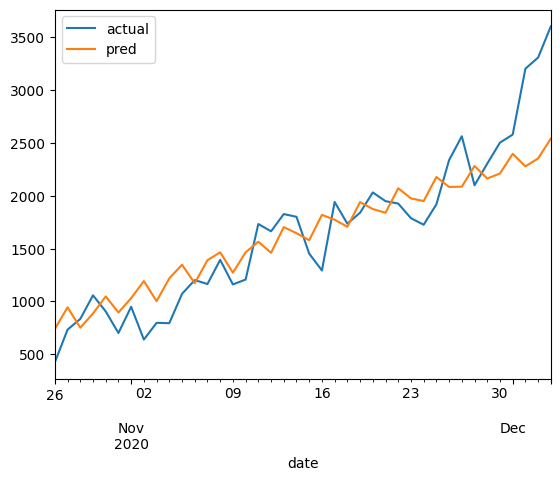

In [ ]:
model = SARIMAX(train.incremental_cases, order = (5, 2, 0),
                      seasonal_order = (5, 0, 0, 12), initialization ='approximate_diffuse').fit(disp=False)
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

P_values = [4, 5, 6]
D_values = [0, 1, 2]
Q_values = [0, 1, 2]

best_score, best_param = float("inf"), None

for P in P_values:
  for D in D_values:
    for Q in Q_values:
      all_mse = 0
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        param = (P, D, Q, 12)
        model = SARIMAX(train_data.incremental_cases, order = (5, 2, 0),
                      seasonal_order = param, initialization ='approximate_diffuse').fit(disp=False)
        pred = model.forecast(steps=val_data.shape[0])
        mse = mean_squared_error(val_data.incremental_cases, pred)
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (4, 0, 0, 12) with mean MSE: 47028.3501695208
params: (4, 0, 1, 12) with mean MSE: 240735.5334285041
params: (4, 0, 2, 12) with mean MSE: 89649.92002358769
params: (4, 1, 0, 12) with mean MSE: 1868138.5797379066
params: (4, 1, 1, 12) with mean MSE: 186608.38406094615
params: (4, 1, 2, 12) with mean MSE: 121886.7921969178
params: (4, 2, 0, 12) with mean MSE: 321203.18682010437
params: (4, 2, 1, 12) with mean MSE: 57169018.644220255
params: (4, 2, 2, 12) with mean MSE: 18579154.997495413
params: (5, 0, 0, 12) with mean MSE: 34636.1727353589
params: (5, 0, 1, 12) with mean MSE: 37959.92802267054
params: (5, 0, 2, 12) with mean MSE: 2002928.3497544762
params: (5, 1, 0, 12) with mean MSE: 616507.1239928001
params: (5, 1, 1, 12) with mean MSE: 194632.7584274105
params: (5, 1, 2, 12) with mean MSE: 674451.325897461
params: (5, 2, 0, 12) with mean MSE: 41492259.32310386
params: (5, 2, 1, 12) with mean MSE: 684098.4460516095
params: (5, 2, 2, 12) with mean MSE: 3219782.9913350367
params

0.7762501659841278


<Axes: xlabel='date'>

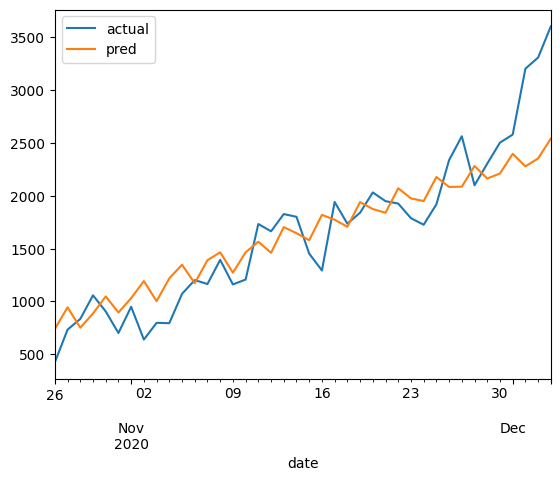

In [ ]:
# still (5, 0, 0, 12) after narrow tuning
model = SARIMAX(train.incremental_cases, order = (5, 2, 0),
                      seasonal_order = (5, 0, 0, 12), initialization ='approximate_diffuse').fit(disp=False)
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

# Suffolk

In [ ]:
suffolk = data[data['county'] == 'Suffolk'].loc[:, ['date', 'incremental_cases']]
suffolk['incremental_cases'] = suffolk['incremental_cases'].astype('int')
suffolk['date'] = pd.to_datetime(suffolk['date'], format="%Y-%m-%d")

# suffolk is non-stationary
print(stationary_test(suffolk.incremental_cases))

# get this value for reversion purposes
print(suffolk.loc[suffolk['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
suffolk['incremental_cases'] = suffolk['incremental_cases'].diff(
).fillna(suffolk['incremental_cases']).astype('int')

# suffolk is still non-stationary after first-level differencing
stationary_test(suffolk.incremental_cases)

# get this value for reversion purposes
print(suffolk.loc[suffolk['date'] == '2020-10-25', 'incremental_cases'])

# second-level differencing
suffolk['incremental_cases'] = suffolk['incremental_cases'].diff(
).fillna(suffolk['incremental_cases']).astype('int')

# suffolk is stationary after second-level differencing
stationary_test(suffolk.incremental_cases)

(-1.991209666592848, 0.2904406048537438)
2389    101
Name: incremental_cases, dtype: int64
2389   -62
Name: incremental_cases, dtype: int64


(-14.698522702913298, 2.9719362953178106e-27)

<Axes: xlabel='date', ylabel='incremental_cases'>

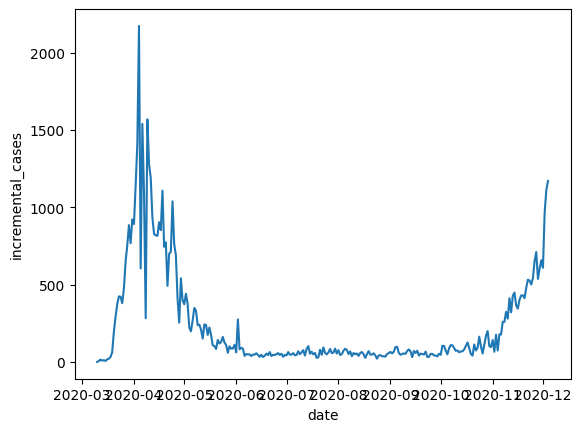

In [ ]:
# use differenced cases for train
train = suffolk.iloc[:230, :]

# use non-differenced cases for test actuals
og = data[data['county'] == 'Suffolk'].loc[:, ['date', 'incremental_cases']]
og.incremental_cases = og.incremental_cases.astype('int')
og.date = pd.to_datetime(og.date, format="%Y-%m-%d")
test = og.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=og)

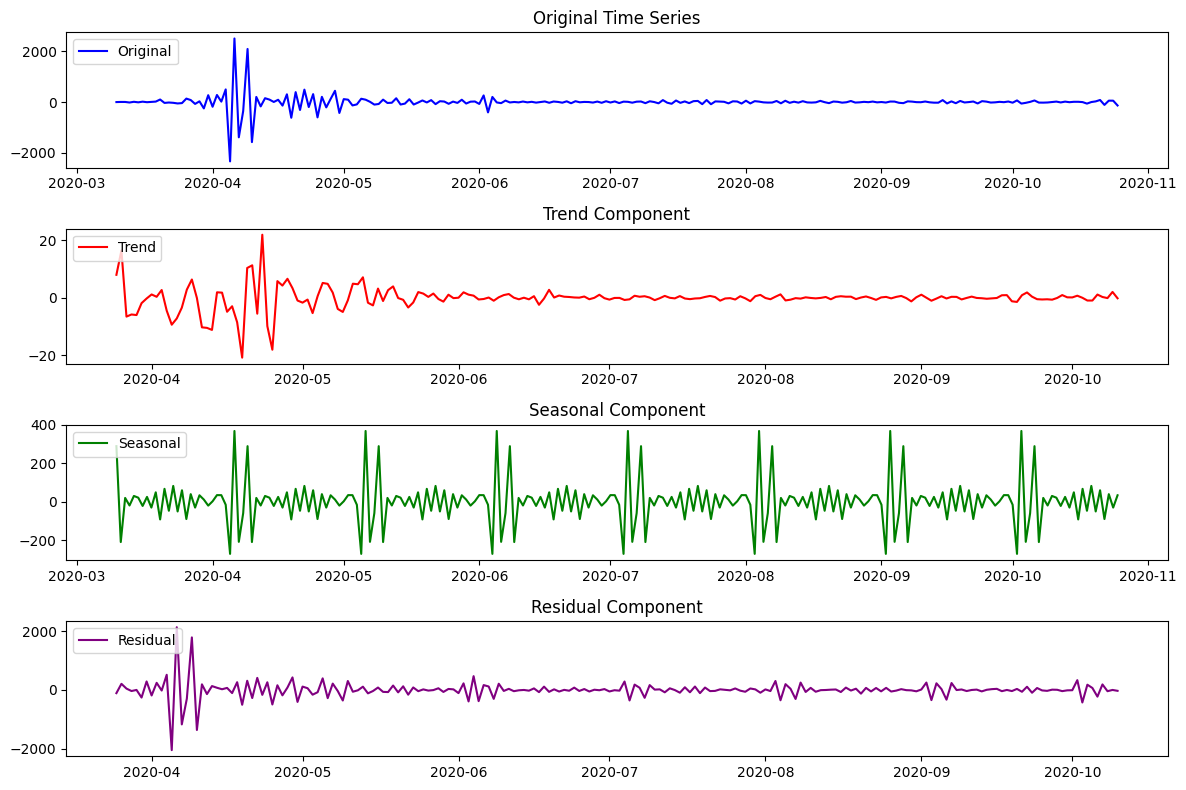

In [ ]:
decomposition = seasonal_decompose(train.incremental_cases, model='additive', period=30)

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(train.date, train.incremental_cases, label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(train.date, decomposition.trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(train.date, decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(train.date, decomposition.resid, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

In [ ]:
best_score, best_param = float("inf"), None

for p in range(1, 6):
  for d in range(0, 4):
    for q in range(1, 6):
      param = (p, d, q)
      # validate on the last 40 entires of train data
      train_data, val_data = train.iloc[:-40], train.iloc[-40:]
      reverse_num = train_data.iloc[-1]
      model = ARIMA(train_data.incremental_cases, order = param).fit()
      pred = pd.concat([pd.Series([reverse_num]), model.forecast(steps=40)]).cumsum()[1:]
      val = pd.concat([pd.Series([reverse_num]), val_data.incremental_cases]).cumsum()[1:]
      pred = model.forecast(steps=40)
      mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=40))
      print(f'params: {param} with MSE: {mse}')
      if mse < best_score:
        best_score, best_param = mse, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (1, 0, 1) with MSE: 1789.2907831615153
params: (1, 0, 2) with MSE: 1831.1312633514797
params: (1, 0, 3) with MSE: 1830.4820937657416
params: (1, 0, 4) with MSE: 1892.710129518761
params: (1, 0, 5) with MSE: 2020.2416723640679
params: (1, 1, 1) with MSE: 1780.3892126316387
params: (1, 1, 2) with MSE: 1789.8274577254826
params: (1, 1, 3) with MSE: 1857.8098967788887
params: (1, 1, 4) with MSE: 2245.934770255525
params: (1, 1, 5) with MSE: 1835.5800828693414
params: (1, 2, 1) with MSE: 3387.645358922785
params: (1, 2, 2) with MSE: 1781.1005545599317
params: (1, 2, 3) with MSE: 1832.0050951042435
params: (1, 2, 4) with MSE: 1886.1519497438508
params: (1, 2, 5) with MSE: 1922.6352051133667
params: (1, 3, 1) with MSE: 2226853.0980285034
params: (1, 3, 2) with MSE: 4701.257733658958
params: (1, 3, 3) with MSE: 1785.5649403010525
params: (1, 3, 4) with MSE: 7066.299533323964
params: (1, 3, 5) with MSE: 2395.350468447386
params: (2, 0, 1) with MSE: 1891.0277095394317
params: (2, 0, 2) w

LinAlgError: LU decomposition error.

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

P_values = [0, 1, 5]
D_values = [0, 1, 2]
Q_values = [0, 1, 5]

best_score, best_param = float("inf"), None

for P in P_values:
  for D in D_values:
    for Q in Q_values:
      all_mse = 0
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        param = (P, D, Q, 12)
        model = SARIMAX(train_data.incremental_cases, order = (5, 2, 10),
                      seasonal_order = param, initialization ='approximate_diffuse').fit(disp=False)
        pred = model.forecast(steps=val_data.shape[0])
        pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
        pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
        mse = mean_squared_error(val_data.incremental_cases, pred)
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0, 12) with mean MSE: 1820907.367727602
params: (0, 0, 1, 12) with mean MSE: 3012616.5686925226
params: (0, 0, 5, 12) with mean MSE: 2663743.246014467
params: (0, 1, 0, 12) with mean MSE: 3873806.004533386
params: (0, 1, 1, 12) with mean MSE: 11890771.364912758
params: (0, 1, 5, 12) with mean MSE: 1881903.2976096056
params: (0, 2, 0, 12) with mean MSE: 23762491.370225057
params: (0, 2, 1, 12) with mean MSE: 11086673.187096585
params: (0, 2, 5, 12) with mean MSE: 30874462.965840805
params: (1, 0, 0, 12) with mean MSE: 1681677.2247887186
params: (1, 0, 1, 12) with mean MSE: 3346575.648193586
params: (1, 0, 5, 12) with mean MSE: 2657262.826450152
params: (1, 1, 0, 12) with mean MSE: 14641658.948897561
params: (1, 1, 1, 12) with mean MSE: 5022667.468223385
params: (1, 1, 5, 12) with mean MSE: 4925339.88880539
params: (1, 2, 0, 12) with mean MSE: 12624859.704295948
params: (1, 2, 1, 12) with mean MSE: 23883586.47920813
params: (1, 2, 5, 12) with mean MSE: 3506953.618264366
pa

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

P_values = [0, 1, 5]
D_values = [0, 1, 2]
Q_values = [0, 1, 5]

best_score, best_param = float("inf"), None

for P in P_values:
  for D in D_values:
    for Q in Q_values:
      all_mse = 0
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        param = (P, D, Q, 12)
        model = SARIMAX(train_data.incremental_cases, order = (5, 2, 10),
                      seasonal_order = param).fit(disp=False)
        pred = model.forecast(steps=val_data.shape[0])
        mse = mean_squared_error(val_data.incremental_cases, pred)
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0, 12) with mean MSE: 8524.324548702341
params: (0, 0, 1, 12) with mean MSE: 3515.2028510819423
params: (0, 0, 5, 12) with mean MSE: 5232.107002471404
params: (0, 1, 0, 12) with mean MSE: 7364.433605295709
params: (0, 1, 1, 12) with mean MSE: 4930.991069167598
params: (0, 1, 5, 12) with mean MSE: 5961.100216536885
params: (0, 2, 0, 12) with mean MSE: 24590.175372442533
params: (0, 2, 1, 12) with mean MSE: 29405.006862567734
params: (0, 2, 5, 12) with mean MSE: 24781.60606971255
params: (1, 0, 0, 12) with mean MSE: 2095.2676231797673
params: (1, 0, 1, 12) with mean MSE: 2611.651333924881
params: (1, 0, 5, 12) with mean MSE: 4483.743467354192
params: (1, 1, 0, 12) with mean MSE: 6796.162515310773
params: (1, 1, 1, 12) with mean MSE: 5590.567519533866
params: (1, 1, 5, 12) with mean MSE: 5132.368799716127
params: (1, 2, 0, 12) with mean MSE: 38349.20018088707
params: (1, 2, 1, 12) with mean MSE: 15086.54806256308
params: (1, 2, 5, 12) with mean MSE: 29821.801058926794
param

0.633037852176211


<Axes: xlabel='date'>

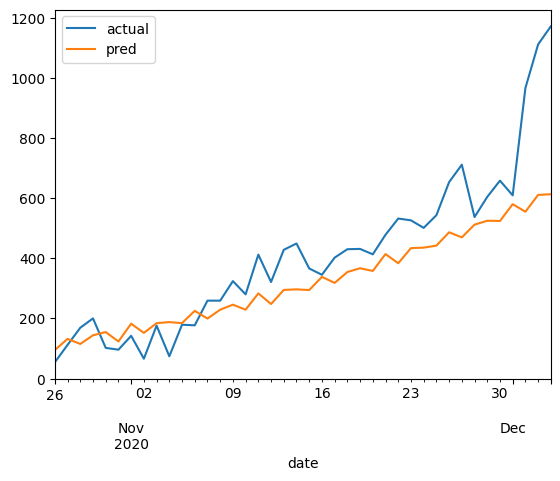

In [ ]:
model = SARIMAX(train.incremental_cases, order = (5, 2, 10),
                      seasonal_order = (1, 0, 0, 12)).fit(disp=False)
pred = model.forecast(steps=40)
pred = pd.concat([pd.Series([-62]), pred]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

# Clark

In [ ]:
clark = data[data['county'] == 'Clark'].loc[:, ['date', 'incremental_cases']]
clark['incremental_cases'] = clark['incremental_cases'].astype('int')
clark['date'] = pd.to_datetime(clark['date'], format="%Y-%m-%d")

# clark is non-stationary
print(stationary_test(clark.incremental_cases))

# get this value for reversion purposes
print(clark.loc[clark['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
clark['incremental_cases'] = clark['incremental_cases'].diff(
).fillna(clark['incremental_cases']).astype('int')

# suffolk is stationary after first-level differencing
print(stationary_test(clark.incremental_cases))

(-0.11236379030359746, 0.9481930426302594)
1579    735
Name: incremental_cases, dtype: int64
(-3.34492010007454, 0.012986122973227106)


<Axes: xlabel='date', ylabel='incremental_cases'>

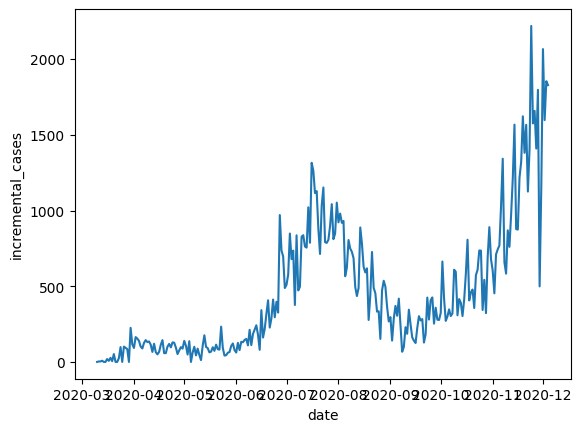

In [ ]:
# use differenced cases for train
train = clark.iloc[:230, :]

# use non-differenced cases for test actuals
og = data[data['county'] == 'Clark'].loc[:, ['date', 'incremental_cases']]
og.incremental_cases = og.incremental_cases.astype('int')
og.date = pd.to_datetime(og.date, format="%Y-%m-%d")
test = og.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=og)

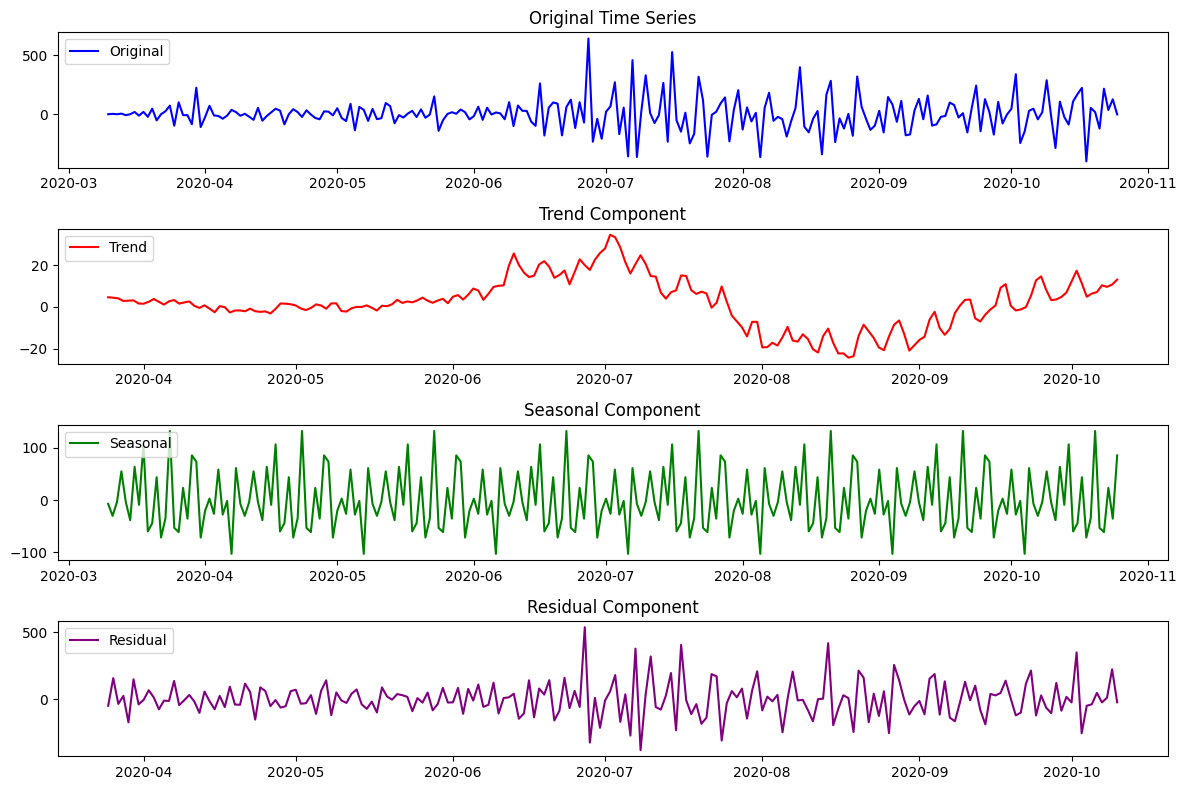

In [ ]:
decomposition = seasonal_decompose(train.incremental_cases, model='additive', period=30)

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(train.date, train.incremental_cases, label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(train.date, decomposition.trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(train.date, decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(train.date, decomposition.resid, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

In [ ]:
og

,date,incremental_cases
1350,2020-03-10,0
1351,2020-03-11,3
1352,2020-03-12,3
1353,2020-03-13,8
1354,2020-03-14,0
...,...,...
1615,2020-11-30,1156
1616,2020-12-01,2066
1617,2020-12-02,1597
1618,2020-12-03,1854


In [ ]:
best_score, best_param = float("inf"), None

for p in range(1, 6):
  for d in range(0, 4):
    for q in range(1, 6):
      param = (p, d, q)
      # validate on the last 40 entires of train data
      train_data, val_data = train.iloc[:-40], train.iloc[-40:]
      reverse_num = og.loc[og['date'] == '2020-09-15', 'incremental_cases']
      model = ARIMA(train_data.incremental_cases, order = param).fit()
      pred = pd.concat([pd.Series([reverse_num]), model.forecast(steps=40)]).cumsum()[1:]
      val = pd.concat([pd.Series([reverse_num]), val_data.incremental_cases]).cumsum()[1:]
      pred = model.forecast(steps=40)
      mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=40))
      print(f'params: {param} with MSE: {mse}')
      if mse < best_score:
        best_score, best_param = mse, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (1, 0, 1) with MSE: 22835.08546262242
params: (1, 0, 2) with MSE: 22842.836709287694
params: (1, 0, 3) with MSE: 22916.90826215859
params: (1, 0, 4) with MSE: 22912.218762552955
params: (1, 0, 5) with MSE: 22810.905877852318
params: (1, 1, 1) with MSE: 22821.76897623806
params: (1, 1, 2) with MSE: 23617.788318999963
params: (1, 1, 3) with MSE: 23393.756570030913
params: (1, 1, 4) with MSE: 23635.087973074315
params: (1, 1, 5) with MSE: 23158.407162629825
params: (1, 2, 1) with MSE: 26976.621547734547
params: (1, 2, 2) with MSE: 24929.32336708079
params: (1, 2, 3) with MSE: 25810.309976186414
params: (1, 2, 4) with MSE: 23444.128871852685
params: (1, 2, 5) with MSE: 23241.843955502078
params: (1, 3, 1) with MSE: 1083157.9374779745
params: (1, 3, 2) with MSE: 23415.70740448361
params: (1, 3, 3) with MSE: 25261.830225357007
params: (1, 3, 4) with MSE: 30387.59725322008
params: (1, 3, 5) with MSE: 27468.90936860607
params: (2, 0, 1) with MSE: 22853.3427181044
params: (2, 0, 2) with

LinAlgError: LU decomposition error.

In [ ]:
best_score, best_param = float("inf"), None

for p in range(1, 4):
    for q in range(1, 4):
      param = (p, 2, q)
      # validate on the last 40 entires of train data
      train_data, val_data = train.iloc[:-40], train.iloc[-40:]
      reverse_num = og.loc[og['date'] == '2020-09-15', 'incremental_cases']
      model = ARIMA(train_data.incremental_cases, order = param).fit()
      pred = pd.concat([pd.Series([reverse_num]), model.forecast(steps=40)]).cumsum()[1:]
      val = pd.concat([pd.Series([reverse_num]), val_data.incremental_cases]).cumsum()[1:]
      pred = model.forecast(steps=40)
      mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=40))
      print(f'params: {param} with MSE: {mse}')
      if mse < best_score:
        best_score, best_param = mse, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (1, 2, 1) with MSE: 26976.621547734547
params: (1, 2, 2) with MSE: 24929.32336708079
params: (1, 2, 3) with MSE: 25810.309976186414
params: (2, 2, 1) with MSE: 29244.227863568183
params: (2, 2, 2) with MSE: 23231.96180122651
params: (2, 2, 3) with MSE: 24810.8804584744
params: (3, 2, 1) with MSE: 26224.503576161504
params: (3, 2, 2) with MSE: 23293.08190837259
params: (3, 2, 3) with MSE: 23869.637340247802
Best ARIMA parameters: (2, 2, 2) with mean MSE: 23231.96180122651


-0.5277864390929792


<Axes: xlabel='date'>

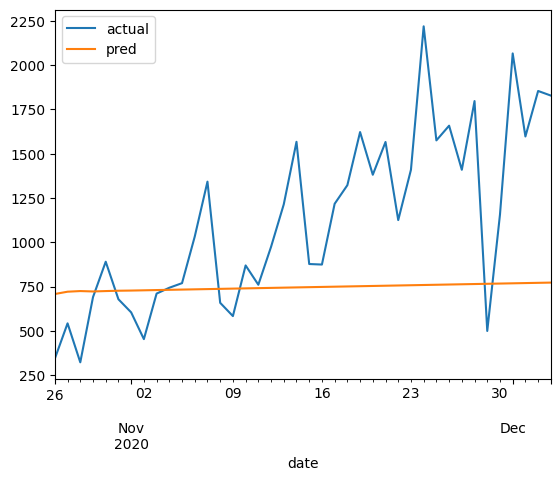

In [ ]:
model = ARIMA(train.incremental_cases, order=(2, 2, 2)).fit()
pred = pd.concat([pd.Series([735]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
model = ARIMA(train_data.incremental_cases, order = (4, 2, 3)).fit()

LinAlgError: LU decomposition error.

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        reverse_num = train_data.iloc[-1]
        print('train:', train_data)
        print('val:', val_data)

int64
train:      incremental_cases
0                    0
1                    3
2                    0
3                    5
4                   -8
..                 ...
105                124
106               -117
107                102
108                -71
109                644

[110 rows x 1 columns]
val:      incremental_cases
110               -234
111                -39
112               -209
113                 21
114                 67
115                272
116               -169
117                 56
118               -359
119                460
120               -364
121                 24
122                331
123                 10
124                -75
125                 -7
126                266
127               -234
128                528
129                -52
130               -148
131                 13
132               -248
133               -167
134                319
135                120
136               -361
137                 -5
138            

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

p_values = [0, 1, 5, 10]
d_values = [0, 1, 2]
q_values = [0, 1, 5, 10]

best_score, best_param = float("inf"), None

for p in p_values:
  for d in d_values:
    for q in q_values:
      all_mse = 0
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        param = (p, d, q)
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        pred = model.forecast(steps=val_data.shape[0])
        mse = mean_squared_error(val_data.incremental_cases, pred)
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

P_values = [0, 1, 5]
D_values = [0, 1, 2]
Q_values = [0, 1, 5]

best_score, best_param = float("inf"), None

for P in P_values:
  for D in D_values:
    for Q in Q_values:
      all_mse = 0
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        param = (P, D, Q, 12)
        model = SARIMAX(train_data.incremental_cases, order = (1, 2, 5),
                      seasonal_order = param).fit(disp=False)
        pred = model.forecast(steps=val_data.shape[0])
        mse = mean_squared_error(val_data.incremental_cases, pred)
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0, 12) with mean MSE: 33817.84621527037
params: (0, 0, 1, 12) with mean MSE: 33526.31266424868
params: (0, 0, 5, 12) with mean MSE: 34250.40656310462
params: (0, 1, 0, 12) with mean MSE: 111776.81807640936
params: (0, 1, 1, 12) with mean MSE: 44667.0770448504
params: (0, 1, 5, 12) with mean MSE: 41113.37077323734
params: (0, 2, 0, 12) with mean MSE: 682448.0072195755
params: (0, 2, 1, 12) with mean MSE: 109500.61505858599
params: (0, 2, 5, 12) with mean MSE: 99226.12808035589
params: (1, 0, 0, 12) with mean MSE: 34715.03528138812
params: (1, 0, 1, 12) with mean MSE: 34730.41514244288
params: (1, 0, 5, 12) with mean MSE: 35317.70981533088
params: (1, 1, 0, 12) with mean MSE: 52983.23904360478
params: (1, 1, 1, 12) with mean MSE: 42636.17915361764
params: (1, 1, 5, 12) with mean MSE: 58753.4789718666


LinAlgError: LU decomposition error.

0.3173325992298609


<Axes: xlabel='date'>

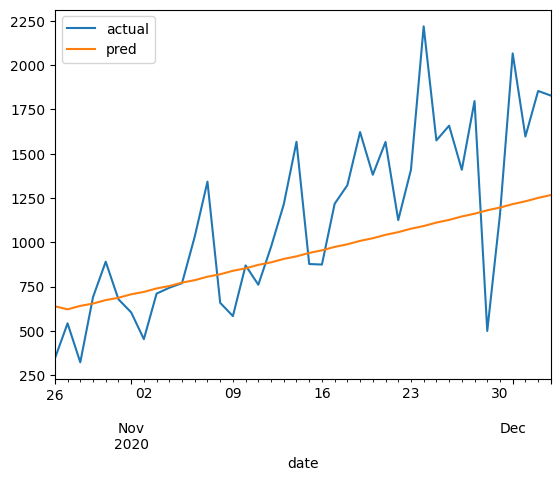

In [ ]:
model = SARIMAX(train.incremental_cases, order = (1, 2, 5),  initialization ='approximate_diffuse').fit(disp=False)
pred = model.forecast(steps=40)
pred = pd.concat([pd.Series([735]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

p_values = [0, 1, 5, 10]
d_values = [0, 2, 4]
q_values = [0, 1, 5, 10]

best_score, best_param = float("inf"), None

for p in p_values:
  for d in d_values:
    for q in q_values:
      all_mse = 0
      param = (p, d, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        reverse_num = train_data.iloc[-1]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        pred = pd.concat([pd.Series([reverse_num]), model.forecast(steps=val_data.shape[0])]).cumsum()[1:]
        val = pd.concat([pd.Series([reverse_num]), val_data.incremental_cases]).cumsum()[1:]
        mse = mean_squared_error(val, pred)
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 0) with mean MSE: 125440.39288023704
params: (0, 0, 1) with mean MSE: 123851.4095121764
params: (0, 0, 5) with mean MSE: 120114.24152129576
params: (0, 0, 10) with mean MSE: 115586.2647479823
params: (0, 1, 0) with mean MSE: 78448901.64166667
params: (0, 1, 1) with mean MSE: 166935.13346253775
params: (0, 1, 5) with mean MSE: 307144.2973851669
params: (0, 1, 10) with mean MSE: 282517.1407521947
params: (0, 2, 0) with mean MSE: 36306960805.59166
params: (0, 2, 1) with mean MSE: 102919331.04287337
params: (0, 2, 5) with mean MSE: 1144492.5244818653
params: (0, 2, 10) with mean MSE: 448305.3085659316
params: (1, 0, 0) with mean MSE: 86607.6190614305
params: (1, 0, 1) with mean MSE: 130428.54604525003
params: (1, 0, 5) with mean MSE: 120295.96712027933
params: (1, 0, 10) with mean MSE: 48678.678166251404
params: (1, 1, 0) with mean MSE: 24919478.954542916
params: (1, 1, 1) with mean MSE: 148807.4912744786
params: (1, 1, 5) with mean MSE: 287340.67229996546
params: (1, 1, 10)

-0.6127553169743614


<Axes: xlabel='date'>

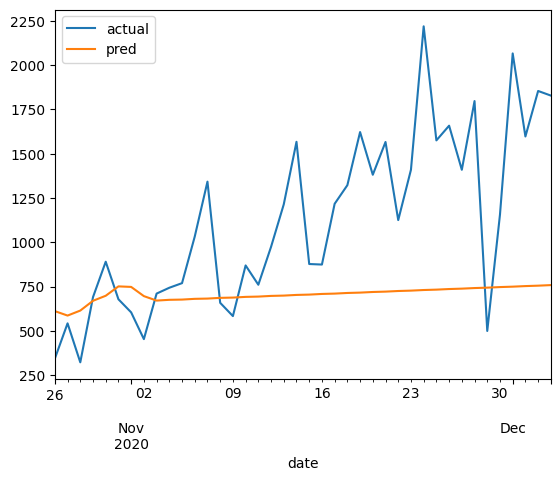

In [ ]:
model = ARIMA(train.incremental_cases, order=(1, 0, 10)).fit()
pred = pd.concat([pd.Series([735]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

-0.3053604829597494


<Axes: xlabel='date'>

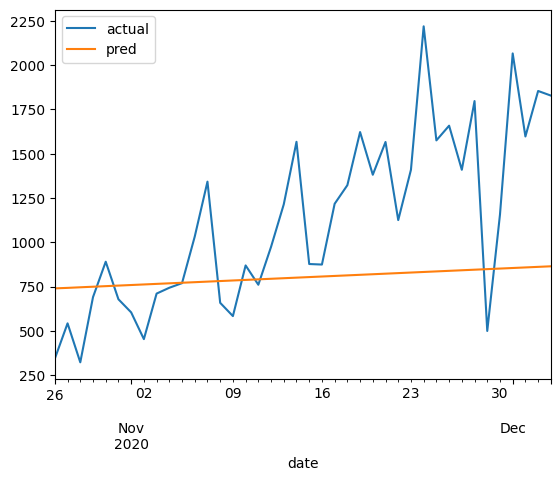

In [ ]:
model = ARIMA(train.incremental_cases, order=(1, 1, 1)).fit()
pred = pd.concat([pd.Series([735]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

-0.3053604829597494


<Axes: xlabel='date'>

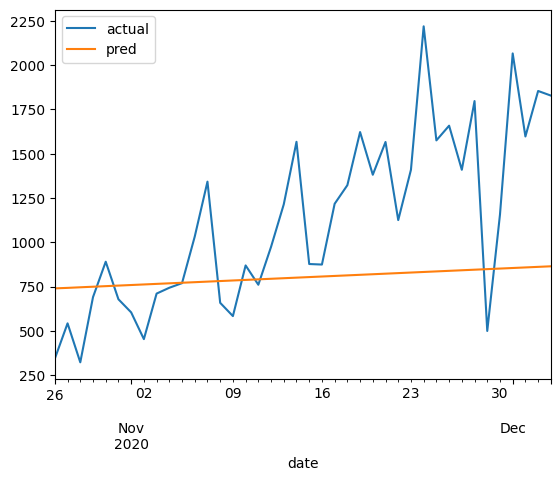

In [ ]:
model = SARIMAX(train.incremental_cases, order = (1, 1, 1),
                      seasonal_order = (0, 0, 0, 12)).fit(disp=False)
pred = pd.concat([pd.Series([735]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
reverse_num = train_data.iloc[-1]

-0.5434050097943144


<Axes: xlabel='date'>

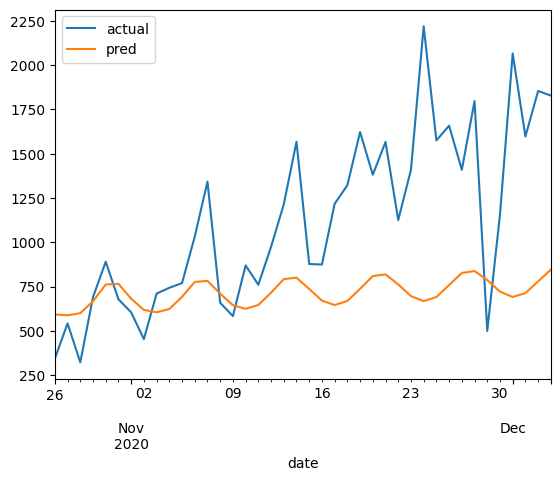

In [ ]:
model = ARIMA(train.incremental_cases, order=(5, 0, 5)).fit()
pred = pd.concat([pd.Series([735]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

P_values = [0, 1, 5]
D_values = [0, 1, 2]
Q_values = [0, 1, 5]

best_score, best_param = float("inf"), None

for P in P_values:
  for D in D_values:
    for Q in Q_values:
      all_mse = 0
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        param = (P, D, Q, 12)
        model = SARIMAX(train_data.incremental_cases, order = (1, 2, 5),
                      seasonal_order = param).fit(disp=False)
        pred = model.forecast(steps=val_data.shape[0])
        mse = mean_squared_error(val_data.incremental_cases, pred)
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')